In [1]:
import xarray as xr
import os, glob, sys
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

root_dir = '/media/harish/SSD_4TB/EU_SCORES_project'
scripts_dir = f'{root_dir}/scripts'
sys.path.append(scripts_dir)

from analysis.plotters import map_plotter, all_sample_points, variability_plotter, months, colors, calculate_color_levels, CERRA_target_grids
from data_processing.libraries import longitude_convert_0_to_360, find_nearest_indice

fig_dir = f'{root_dir}/Reports/All_CERRA'

#### Major differences with the WRF data
- XLAT -> latitude
- XLONG -> longitude
- south_north -> y
- west_east -> x
- Time -> time
- T2 -> t2m
- SWDOWN2 -> swdown
- hour[::3] -> hour
- calculate_color_levels(ds.overall_values.isel(y=slice(20,-10),x=slice(10,-45))) -> calculate_color_levels(ds.overall_values)
- map_plotter([10:-10,10:-10]) -> no subsetting
- all_sample_points keys -> ['Iberia','Ireland','BeNeLux']
- No Extent -> Extent

In [2]:
# Mapping of common keys to desired keys
key_mapping = {
    'Portugal_coast': 'Iberia',
    'Netherlands_coast': 'BeNeLux',
    'Ireland_coast': 'Ireland'
}
# Creating a new dictionary with the desired keys
all_sample_points = {key_mapping[key]: points for key, points in all_sample_points.items()}

In [3]:
run = 'New_runs'
cases = ['Iberia','Ireland','BeNeLux']
fig_widths = {'Iberia': 6,
              'Ireland': 6,
              'BeNeLux': 6}
fig_heights = {'Iberia': 5,
              'Ireland': 4,
              'BeNeLux': 4}
cmap = 'tab20b'
months_indices = [12,1,2,3,4,5,6,7,8,9,10,11]
months_in_seasonal_order = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
cell_watt = 365

In [4]:
def overall_interannual_plotter(ds,case,title_key,units,target_fig_suffix,lsm):
    fig = plt.figure(figsize=(18, 5), constrained_layout=True)
    gs = fig.add_gridspec(1,3)

    clevel = calculate_color_levels(ds.overall_values.where(lsm == 0))
    if len(clevel) < 2:
        pass
    cbar_args= {'shrink':1,'cbar_label':f'{units}','orientation':'horizontal'}
    extent = [CERRA_target_grids[case]['min_lon'],CERRA_target_grids[case]['max_lon'],CERRA_target_grids[case]['min_lat'],CERRA_target_grids[case]['max_lat']]
    map_plotter(fig,gs[0,0],ds.overall_values,'longitude','latitude',
                clevel,cmap,f'Overall {title_key} (1990-2020)',cbar_args,extent=extent,
                sample_points = all_sample_points[case])

    overall_df = pd.DataFrame()
    yearly_df = pd.DataFrame()
    for i,key in enumerate(all_sample_points[case].keys()):
        indices = find_nearest_indice(ds.latitude,ds.longitude,all_sample_points[case][key][0],all_sample_points[case][key][1],lon_convert=True)

        data = ds.overall_values.sel(y=indices[0],x=indices[1]).values
        pointwise_df = pd.DataFrame({key: data}, index=pd.Index([0],name='Overall'))
        overall_df = pd.concat([overall_df, pointwise_df],axis=1)

        data = ds.yearly_values.sel(y=indices[0],x=indices[1]).values
        pointwise_df = pd.DataFrame({key: data}, index=pd.Index(ds.year, name='year'))
        yearly_df = pd.concat([yearly_df, pointwise_df],axis=1)
        
    ylabel = f'{units}'
    axs = variability_plotter(fig,gs[0,1:3],yearly_df,None,f'{title_key} Interannual variability (1990-2020)',
                        'Years',ylabel,None,None,None)

    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.7, -0.00),fontsize=14)

    plt.savefig(f'{target_fig_suffix}_overall_and_interannual_variability.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [5]:
def monthly_annual_plotter(ds,case,title_key,units,target_fig_suffix,lsm):
    
    cbar_args = {'shrink':1,'cbar_label':f'{units}','orientation':'horizontal'}
    extent = [CERRA_target_grids[case]['min_lon'],CERRA_target_grids[case]['max_lon'],CERRA_target_grids[case]['min_lat'],CERRA_target_grids[case]['max_lat']]
    rows, cols = 4,3
    fig = plt.figure(figsize=(6*cols, rows*fig_heights[case]), constrained_layout=True)
    gs = fig.add_gridspec(rows,cols)
    for i,month in enumerate(months_indices):
        clevel = calculate_color_levels(ds.monthly_values.sel(month=month).where(lsm == 0))
        if len(clevel) < 2:
            continue
        axs = map_plotter(fig,gs[i//cols,i%cols],ds.monthly_values.sel(month=month),'longitude','latitude',
                clevel,cmap,f'{months[month-1]}',cbar_args,extent=extent,
                sample_points = None)
    plt.savefig(f'{target_fig_suffix}_monthly.png',dpi=300,bbox_inches='tight',pad_inches=0)

    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(1,1)

    overall_df = pd.DataFrame()
    monthly_df = pd.DataFrame()
    for i,key in enumerate(all_sample_points[case].keys()):
        indices = find_nearest_indice(ds.latitude,ds.longitude,all_sample_points[case][key][0],all_sample_points[case][key][1],lon_convert=True)

        data = ds.overall_values.sel(y=indices[0],x=indices[1]).values
        pointwise_df = pd.DataFrame({key: data}, index=pd.Index([0],name='Overall'))
        overall_df = pd.concat([overall_df, pointwise_df],axis=1)

        data = ds.monthly_values.sel(y=indices[0],x=indices[1]).values
        pointwise_df = pd.DataFrame({key: data}, index=pd.Index(months, name='month'))
        monthly_df = pd.concat([monthly_df, pointwise_df],axis=1)
    monthly_df = monthly_df.reindex(months_in_seasonal_order)

    xlabel_ticks = months_in_seasonal_order
    ylabel = f'{units}'
    axs = variability_plotter(fig,gs[0,0],monthly_df,overall_df,f'{title_key} annual variability (1990-2020)',
                        'Months',ylabel,None,None,None,xlabel_ticks=xlabel_ticks)
    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.1),fontsize=14)

    plt.savefig(f'{target_fig_suffix}_annual_variability.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [6]:
def hourly_diurnal_plotter(ds,case,title_key,units,target_fig_suffix,lsm):
    cbar_args={'shrink':1,'cbar_label':f'{units}','orientation':'horizontal'}
    extent = [CERRA_target_grids[case]['min_lon'],CERRA_target_grids[case]['max_lon'],CERRA_target_grids[case]['min_lat'],CERRA_target_grids[case]['max_lat']]
    rows, cols = 4,2
    fig = plt.figure(figsize=(6*cols, rows*fig_heights[case]), constrained_layout=True)
    gs = fig.add_gridspec(rows,cols)
    for i,hour in enumerate(ds.hour.values):
        clevel = calculate_color_levels(ds.hourly_values.sel(hour=hour).where(lsm == 0))
        if len(clevel) < 2:
            continue
        axs = map_plotter(fig,gs[i//cols,i%cols],ds.hourly_values.sel(hour=hour),'longitude','latitude',
                clevel,cmap,f'Hour: {hour}',cbar_args,extent=extent,
                sample_points = None)
    plt.savefig(f'{target_fig_suffix}_hourly.png',dpi=300,bbox_inches='tight',pad_inches=0)


    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(1,1)

    overall_df = pd.DataFrame()
    hourly_df = pd.DataFrame()
    for i,key in enumerate(all_sample_points[case].keys()):
        indices = find_nearest_indice(ds.latitude,ds.longitude,all_sample_points[case][key][0],all_sample_points[case][key][1],lon_convert=True)

        data = ds.overall_values.sel(y=indices[0],x=indices[1]).values
        pointwise_df = pd.DataFrame({key: data}, index=pd.Index([0],name='Overall'))
        overall_df = pd.concat([overall_df, pointwise_df],axis=1)

        data = ds.hourly_values.sel(y=indices[0],x=indices[1]).values
        pointwise_df = pd.DataFrame({key: data}, index=pd.Index(ds.hour, name='hour'))
        hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

    xlabel_ticks = ds.hour.values
    ylabel = f'{units}'
    axs = variability_plotter(fig,gs[j,0],hourly_df,overall_df,f'{title_key} diurnal variability (1990-2020)',
                        'Hours',ylabel,None,None,None,xlabel_ticks=xlabel_ticks)
    # Extract legend from one of the subplots
    handles, labels = axs.get_legend_handles_labels()
    # Create a common legend below the figures
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.1),fontsize=14)

    plt.savefig(f'{target_fig_suffix}_diurnal_variability.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [7]:
def process_data(ds, target_dir,case,variable, statistic, v_info,target_fig_suffix,lsm):
    if statistic == 'weibull' and os.path.exists(f'{target_dir}/weibull.nc'):
        for parameter in ['scale', 'shape']:
            units = v_info['units'] if parameter == 'scale' else ''
            if parameter == 'scale':
                print(target_fig_suffix,parameter,'overall and annual plots')
                overall_interannual_plotter(ds.sel(parameter=parameter),case,f'{statistic} {parameter}',units,f'{target_fig_suffix}_{parameter}',lsm)
                print(target_fig_suffix,parameter,'monthly and diurnal plots')
                monthly_annual_plotter(ds.sel(parameter=parameter),case,f'{statistic} {parameter}',units,f'{target_fig_suffix}_{parameter}',lsm)
            else:
                print(target_fig_suffix,parameter,'monthly and diurnal plots')
                overall_interannual_plotter(ds.sel(parameter=parameter),case,f'{statistic} {parameter}',units,f'{target_fig_suffix}_{parameter}',lsm)
    elif statistic == 'mean': 
        if not os.path.exists(f'{target_dir}/weibull.nc'):
            units = v_info['units']
            print(target_fig_suffix,statistic,'overall and annual plots')
            overall_interannual_plotter(ds,case,f'{statistic}',units,target_fig_suffix,lsm)
            print(target_fig_suffix,statistic,'monthly and diurnal plots')
            monthly_annual_plotter(ds,case,f'{statistic}',units,target_fig_suffix,lsm)
    else:
        units = '' if statistic == 'cov' else v_info['units']
        print(target_fig_suffix,statistic,'overall and annual plots')
        overall_interannual_plotter(ds,case,f'{statistic}',units,target_fig_suffix,lsm)

/media/harish/SSD_4TB/EU_SCORES_project/Reports/All_CERRA/Iberia_t2m_mean mean overall and annual plots
Closest indices in the order of latitude (y) and longitude (x) are : (17, 27)
Closest indices in the order of latitude (y) and longitude (x) are : (21, 25)
Closest indices in the order of latitude (y) and longitude (x) are : (25, 24)
/media/harish/SSD_4TB/EU_SCORES_project/Reports/All_CERRA/Iberia_t2m_mean mean monthly and diurnal plots
Closest indices in the order of latitude (y) and longitude (x) are : (17, 27)
Closest indices in the order of latitude (y) and longitude (x) are : (21, 25)
Closest indices in the order of latitude (y) and longitude (x) are : (25, 24)
/media/harish/SSD_4TB/EU_SCORES_project/Reports/All_CERRA/Iberia_t2m_cov cov overall and annual plots
Closest indices in the order of latitude (y) and longitude (x) are : (17, 27)
Closest indices in the order of latitude (y) and longitude (x) are : (21, 25)
Closest indices in the order of latitude (y) and longitude (x) ar

/tmp/ipykernel_57450/2185552618.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(18, 5), constrained_layout=True)


/media/harish/SSD_4TB/EU_SCORES_project/Reports/All_CERRA/Ireland_swdown_mean mean overall and annual plots
Closest indices in the order of latitude (y) and longitude (x) are : (17, 21)
Closest indices in the order of latitude (y) and longitude (x) are : (22, 25)
Closest indices in the order of latitude (y) and longitude (x) are : (24, 21)
/media/harish/SSD_4TB/EU_SCORES_project/Reports/All_CERRA/Ireland_swdown_mean mean monthly and diurnal plots
Closest indices in the order of latitude (y) and longitude (x) are : (17, 21)
Closest indices in the order of latitude (y) and longitude (x) are : (22, 25)
Closest indices in the order of latitude (y) and longitude (x) are : (24, 21)
/media/harish/SSD_4TB/EU_SCORES_project/Reports/All_CERRA/Ireland_swdown_cov cov overall and annual plots
Closest indices in the order of latitude (y) and longitude (x) are : (17, 21)
Closest indices in the order of latitude (y) and longitude (x) are : (22, 25)
Closest indices in the order of latitude (y) and long

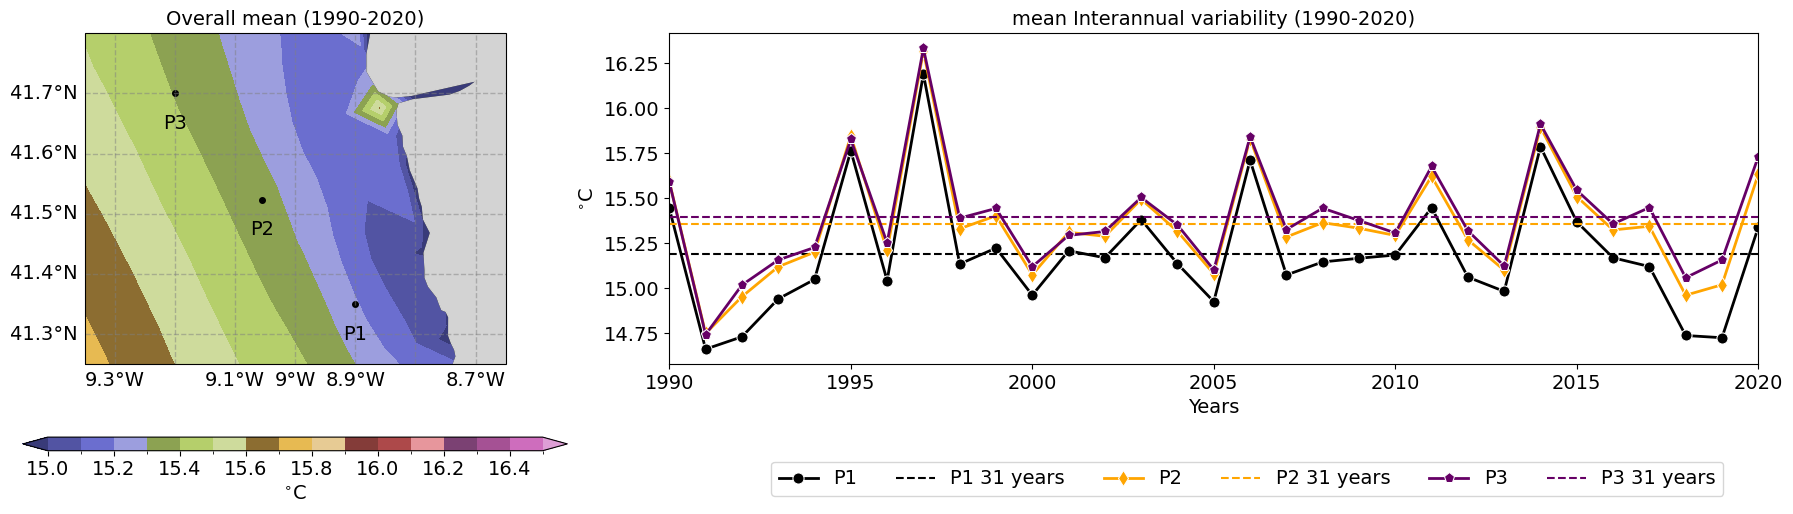

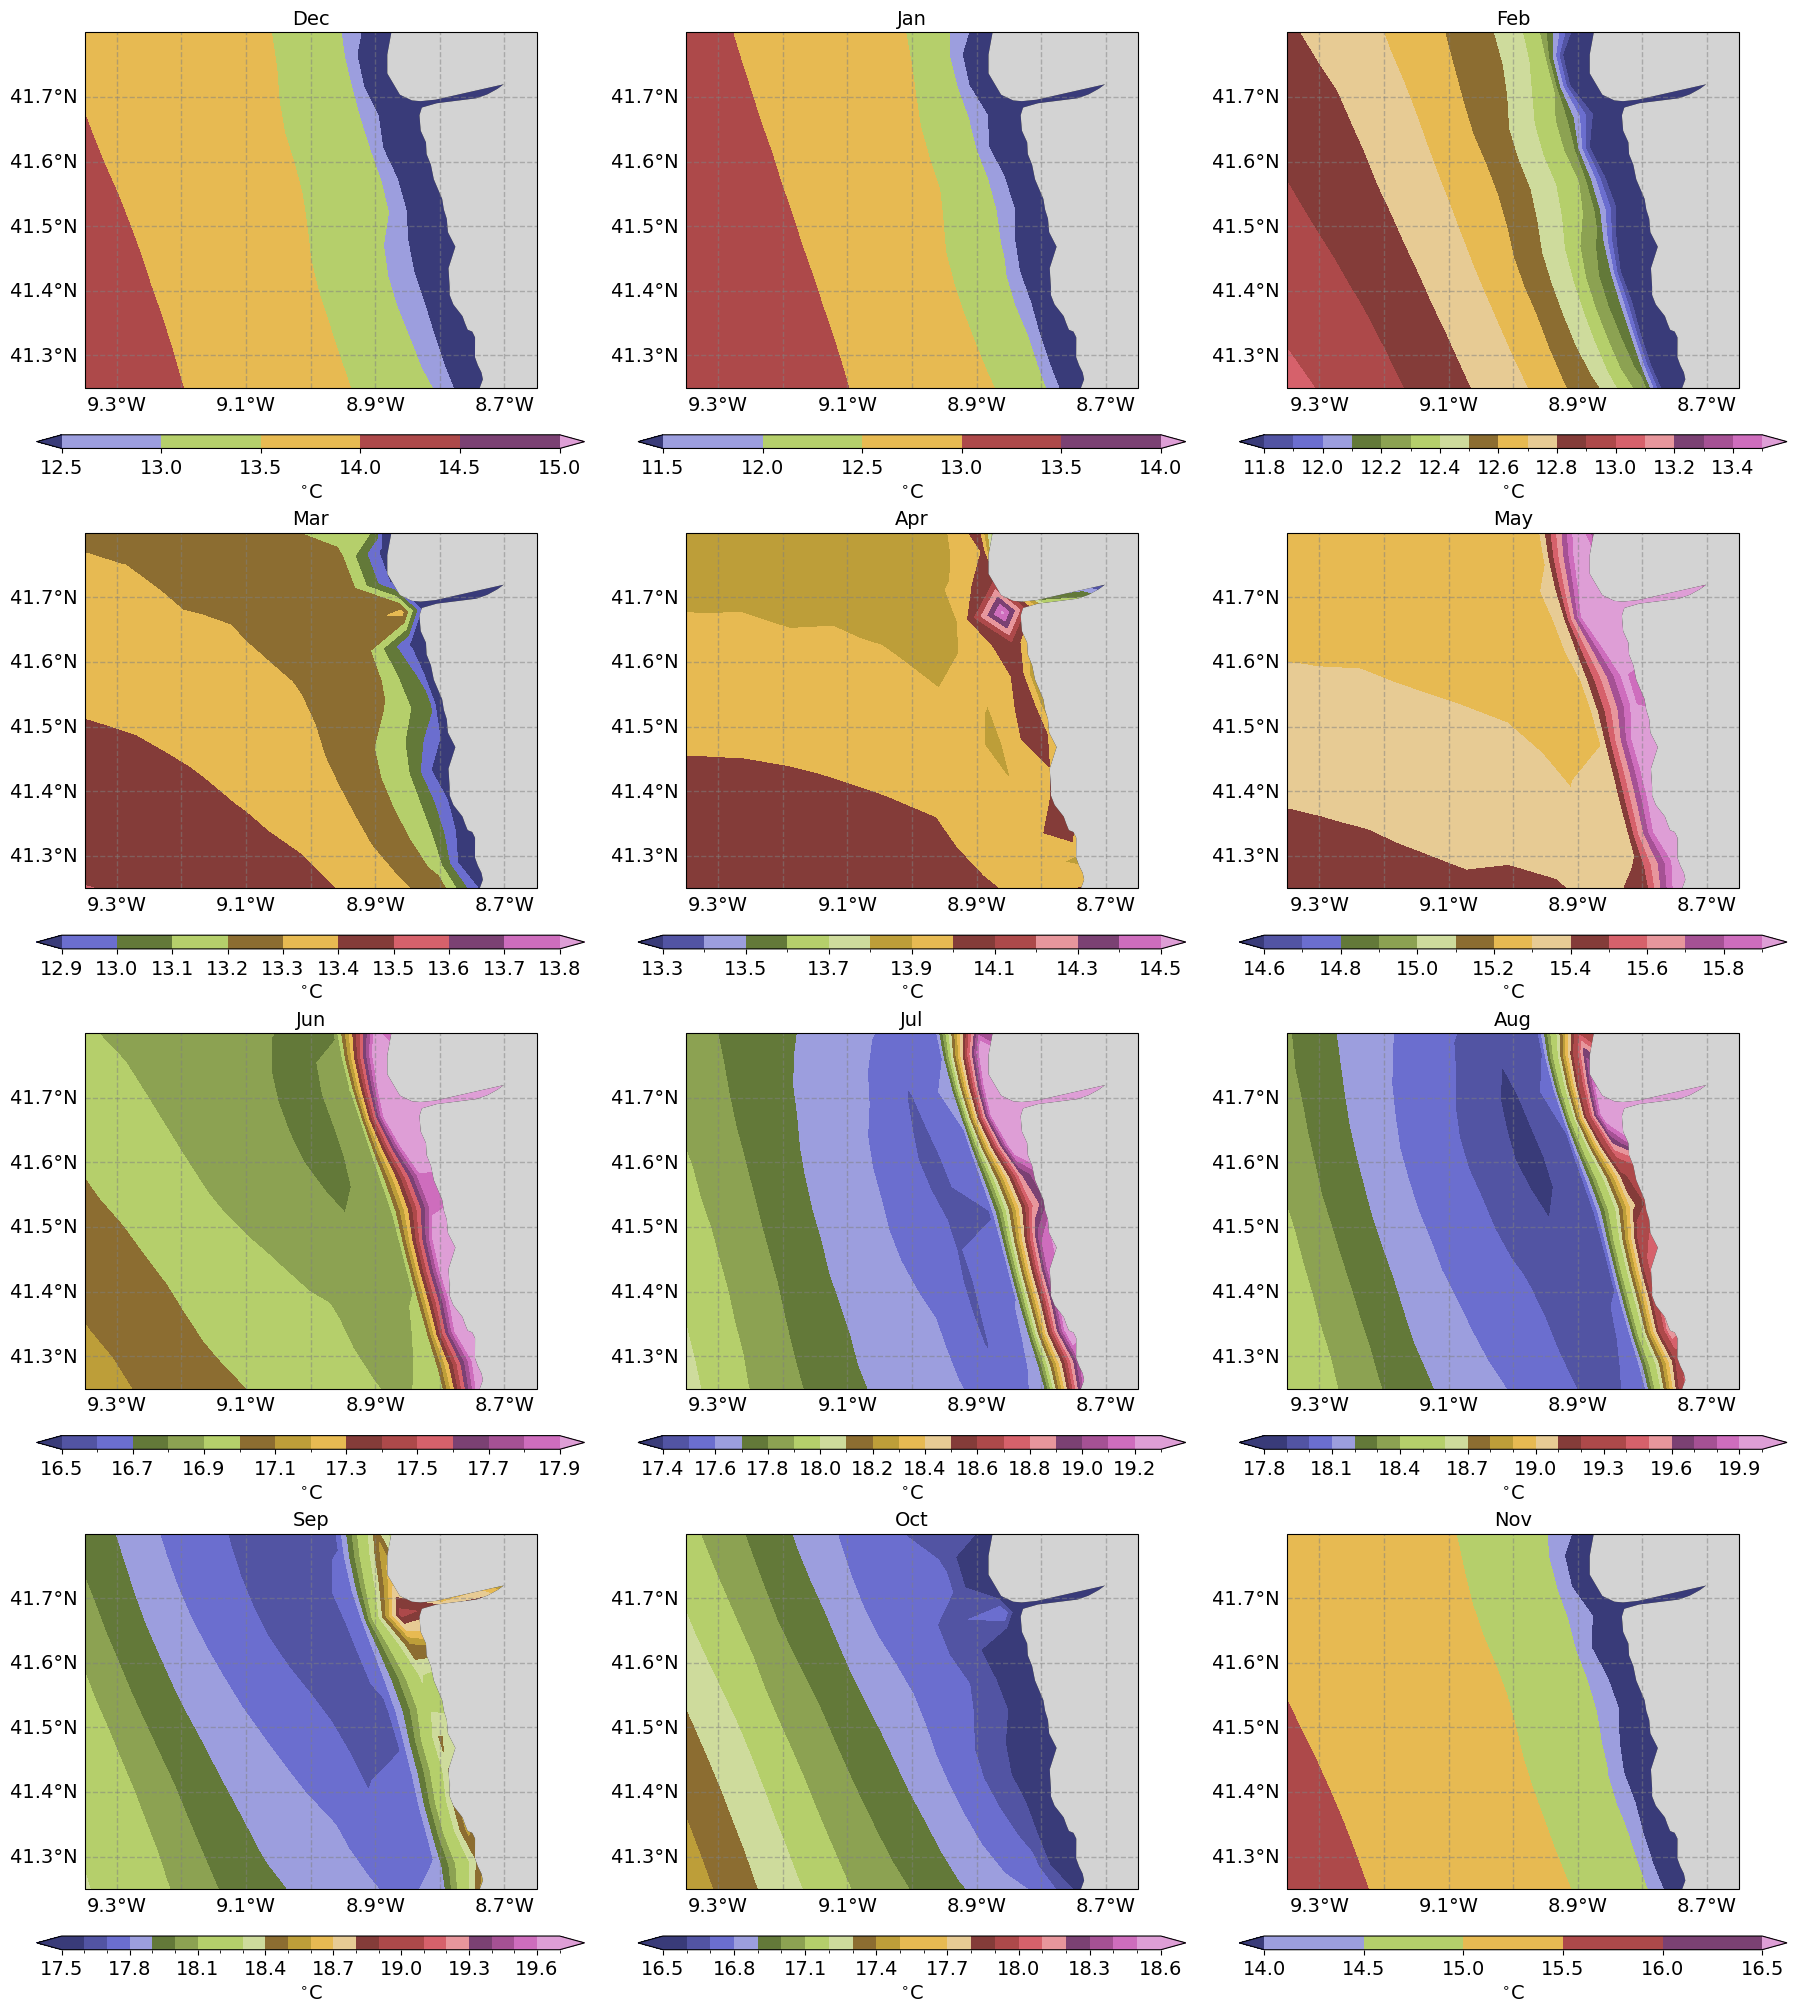

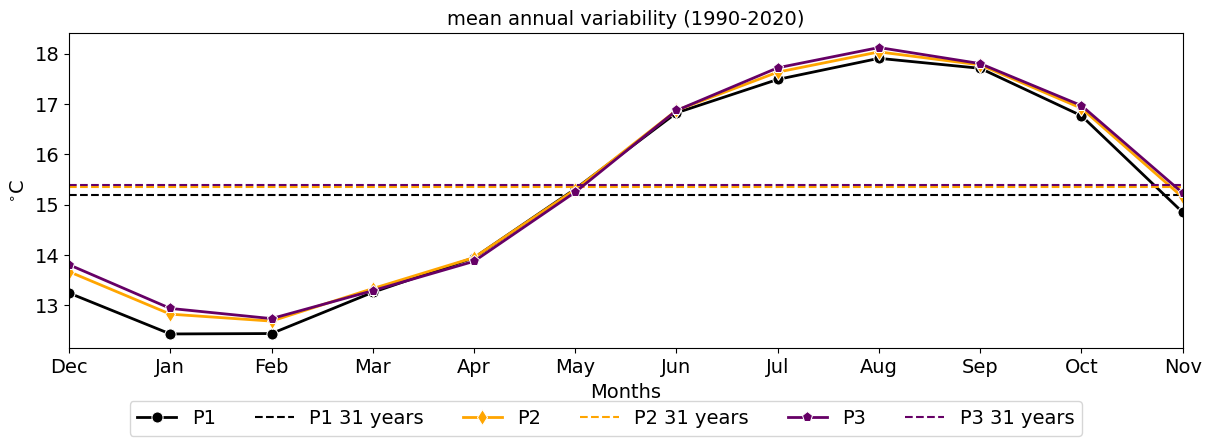

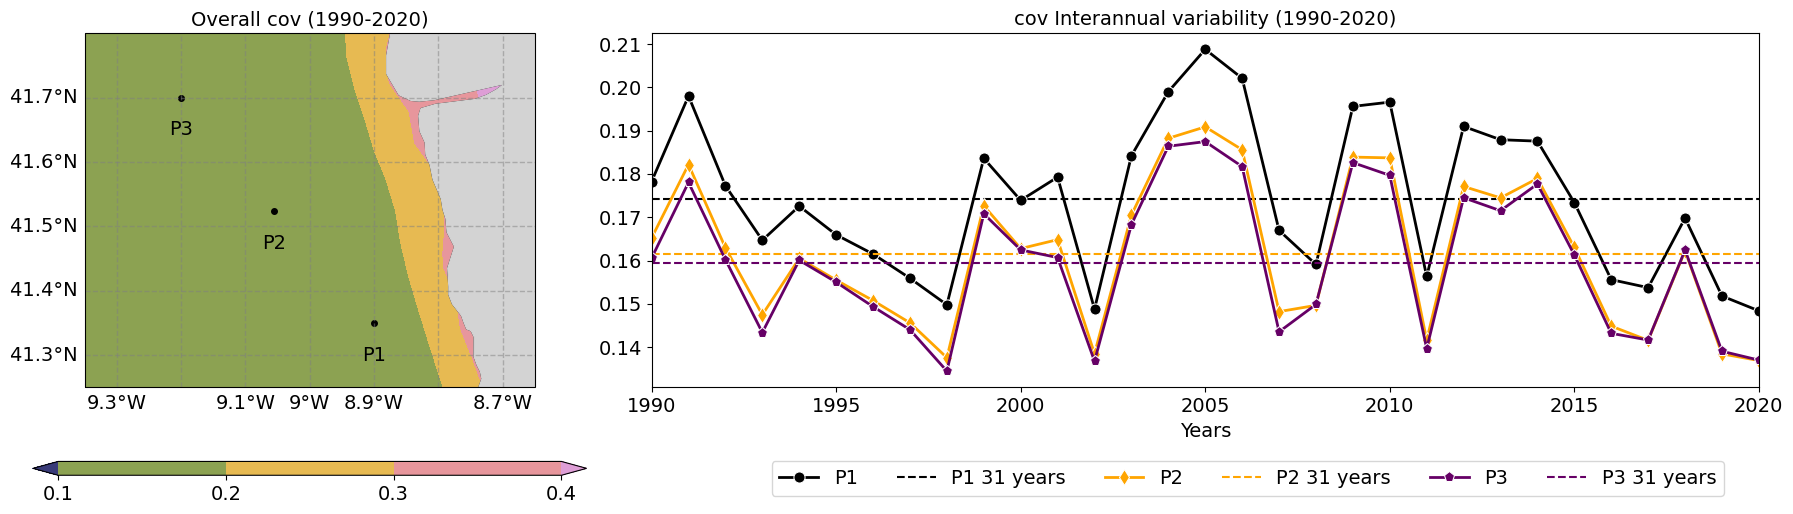

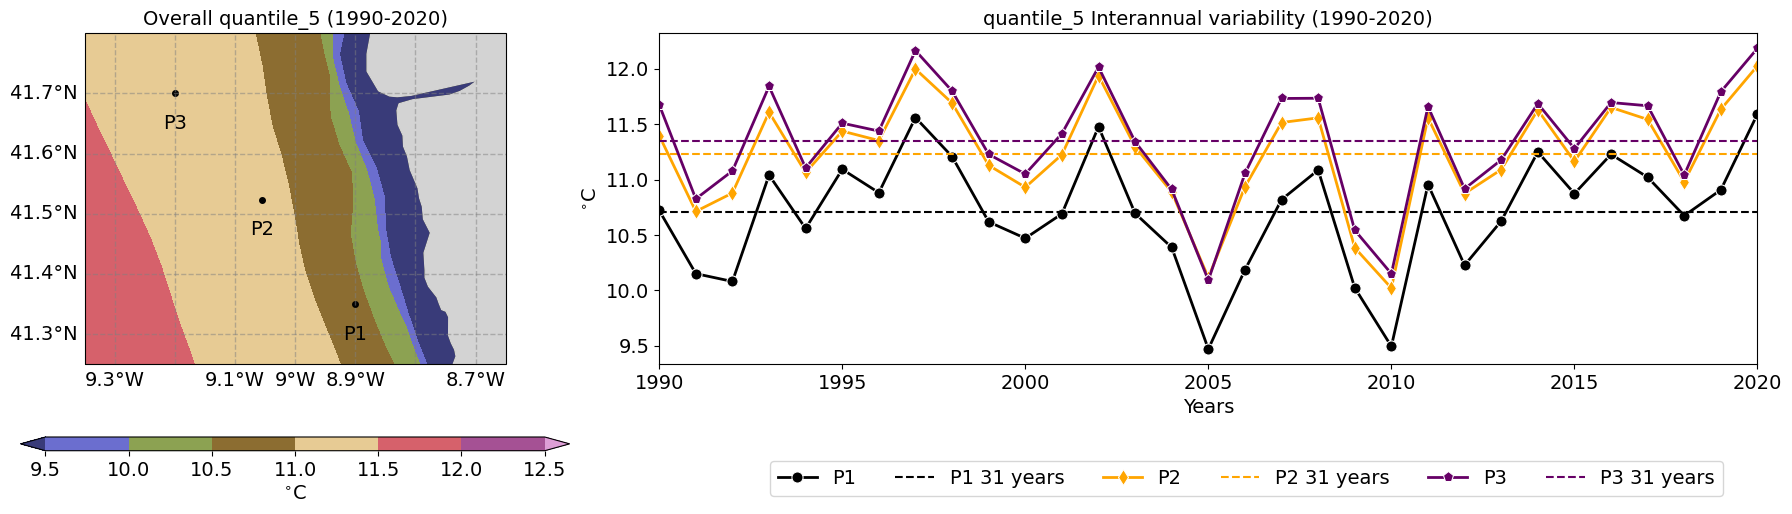

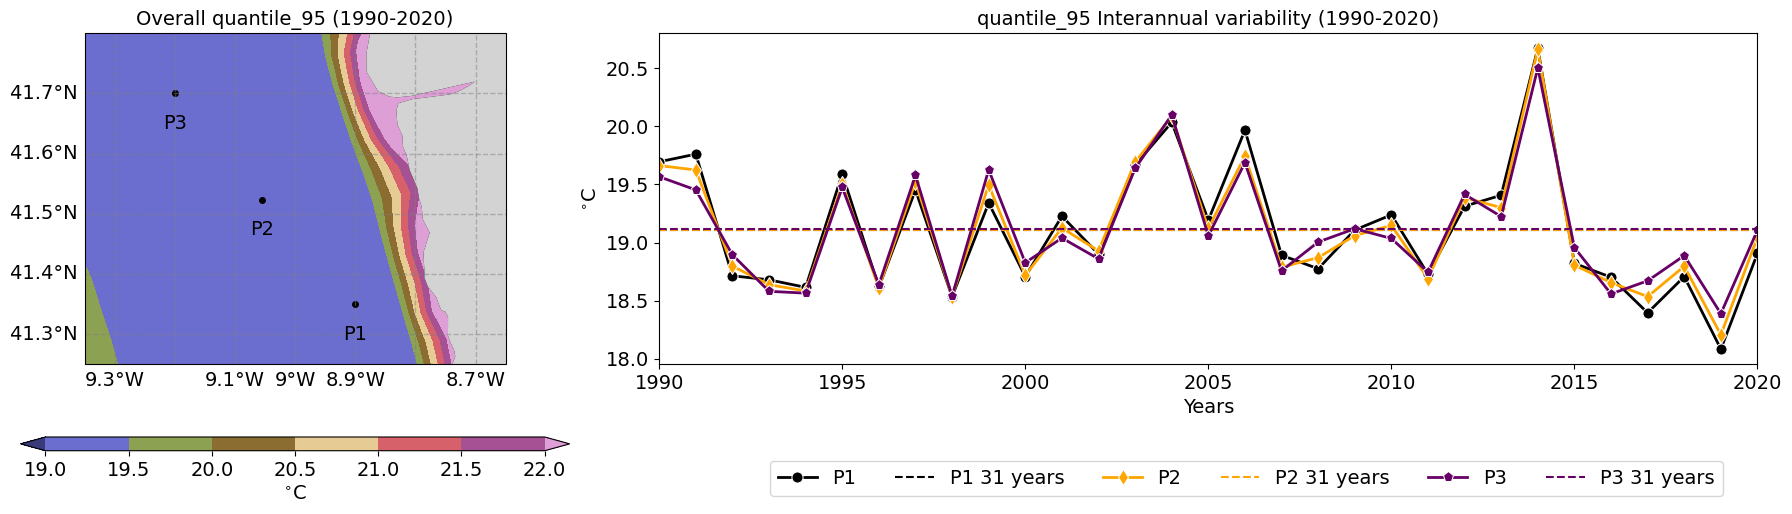

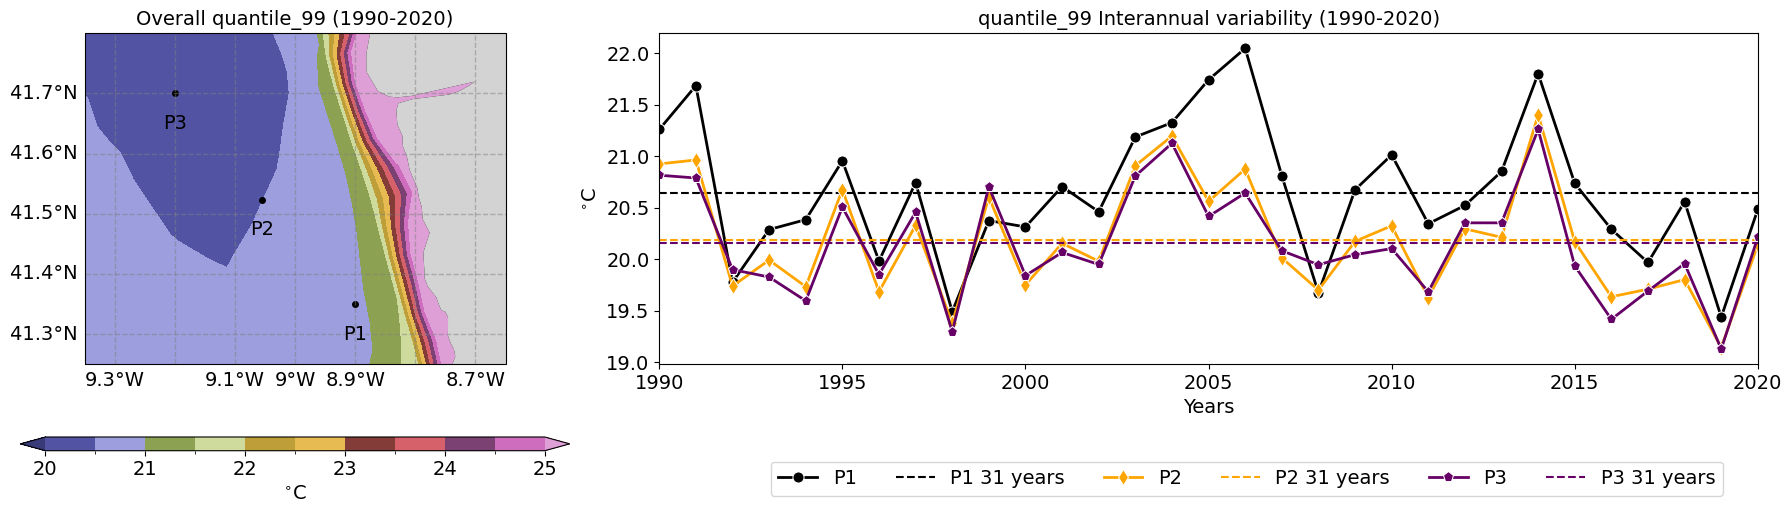

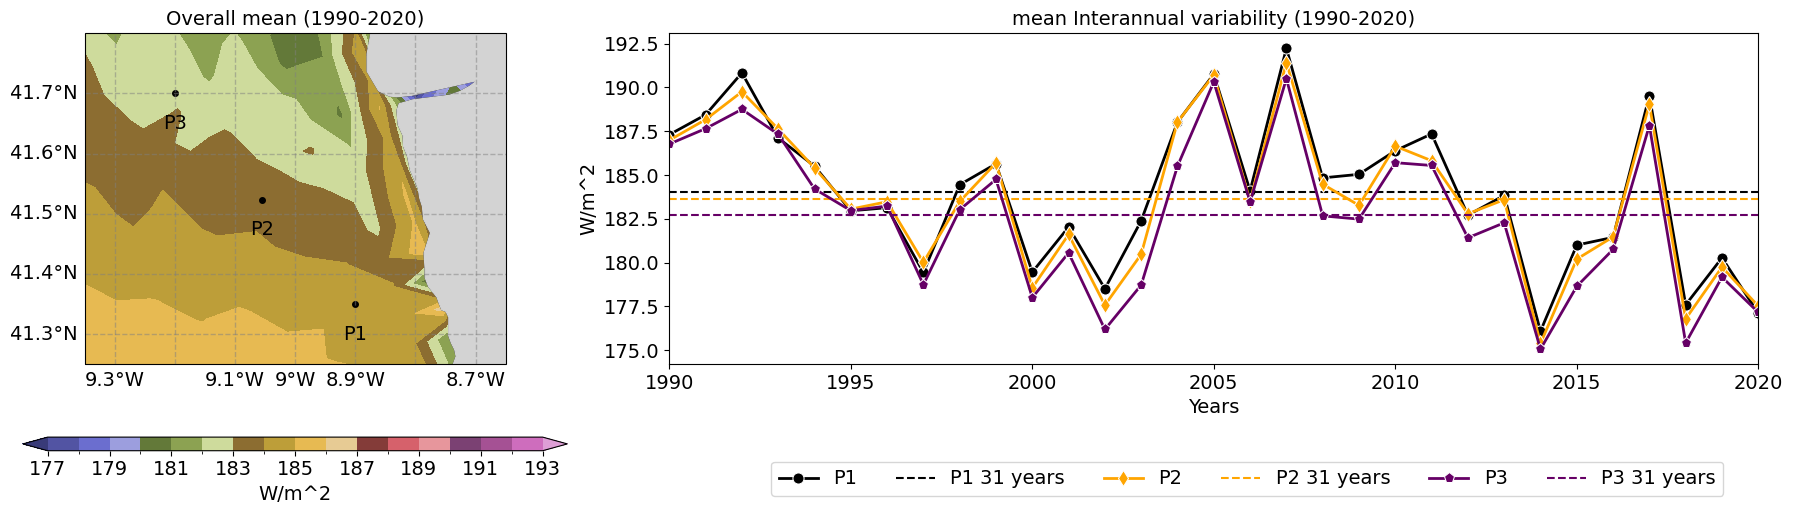

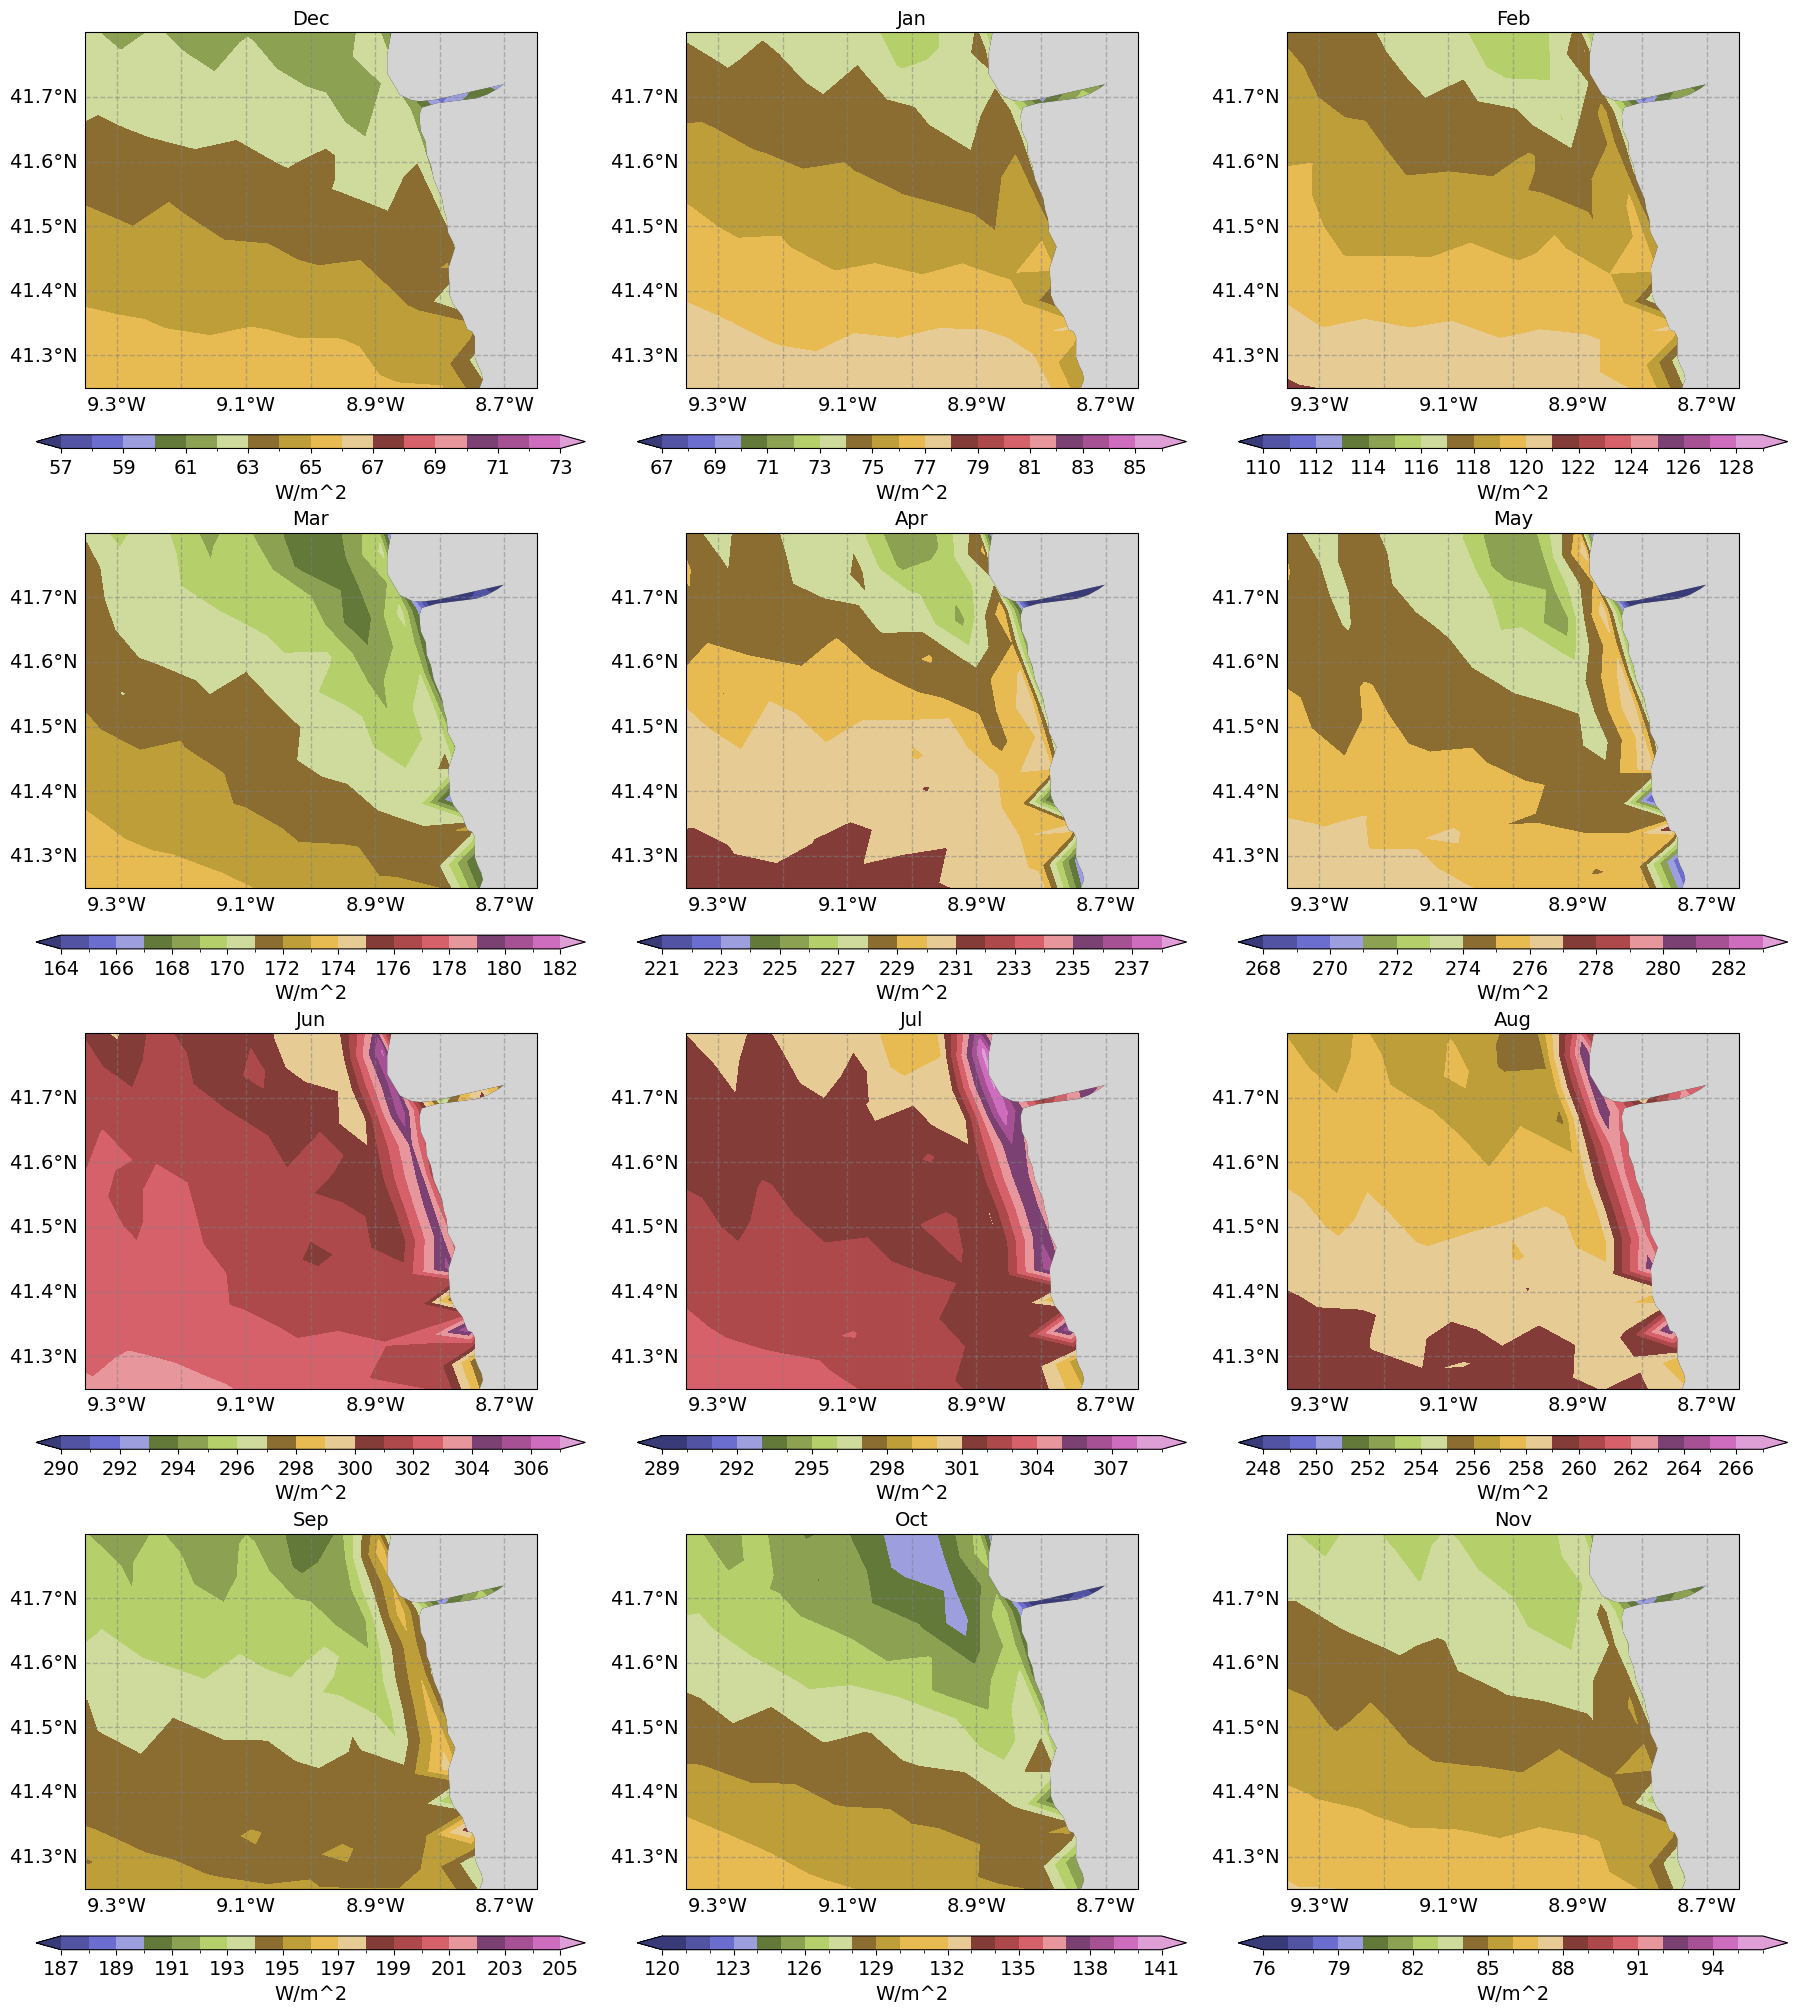

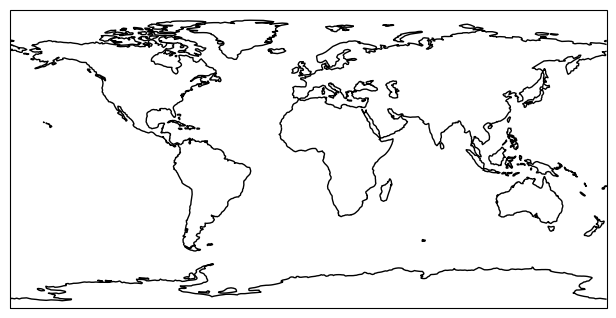

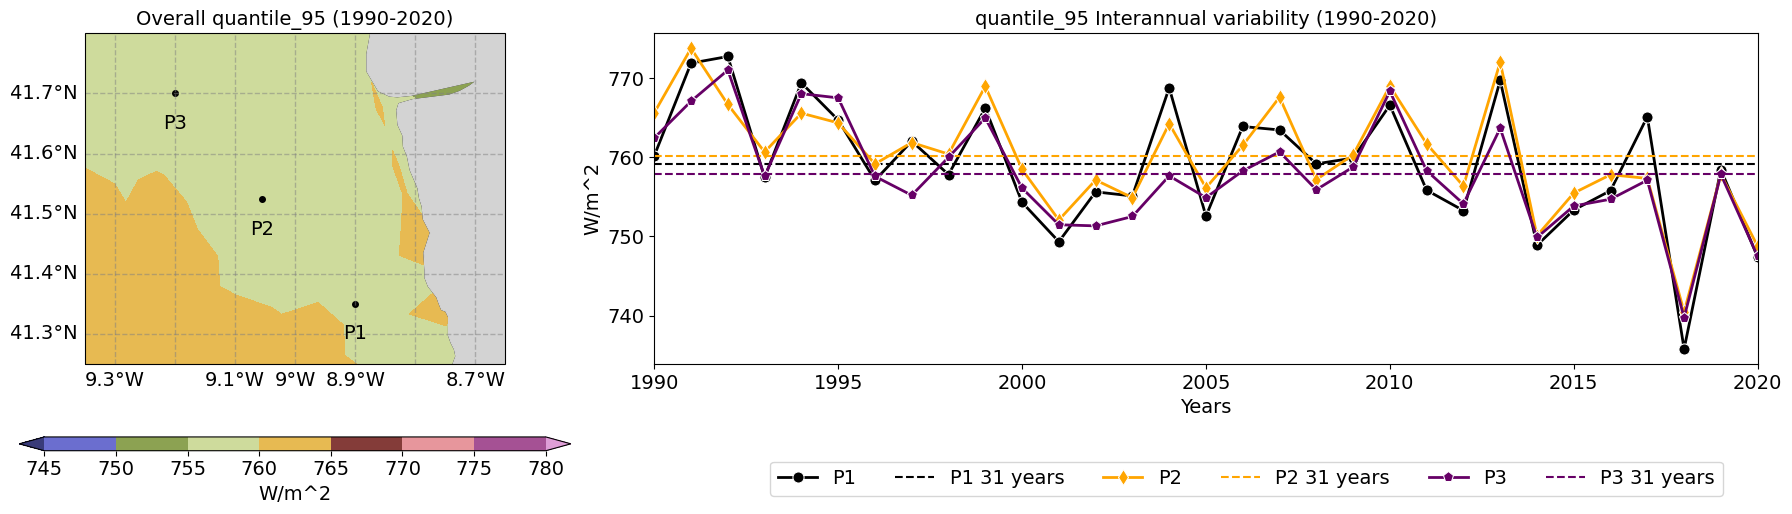

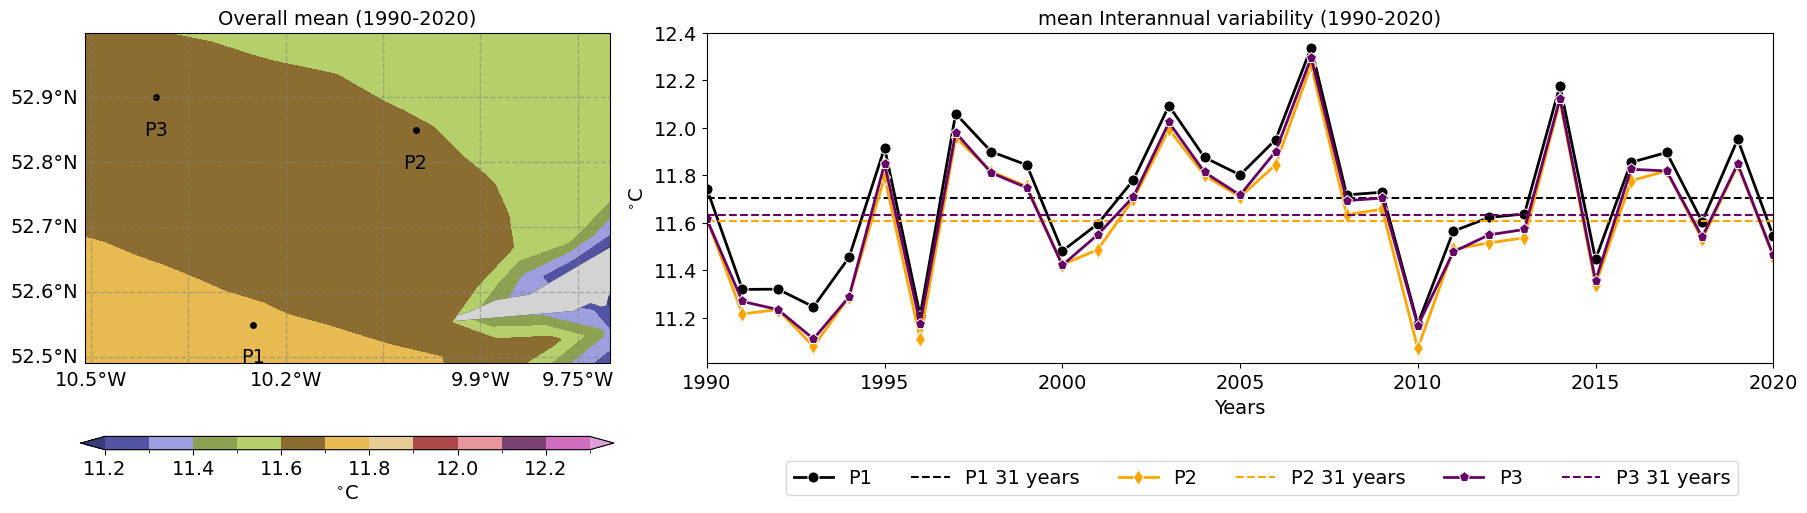

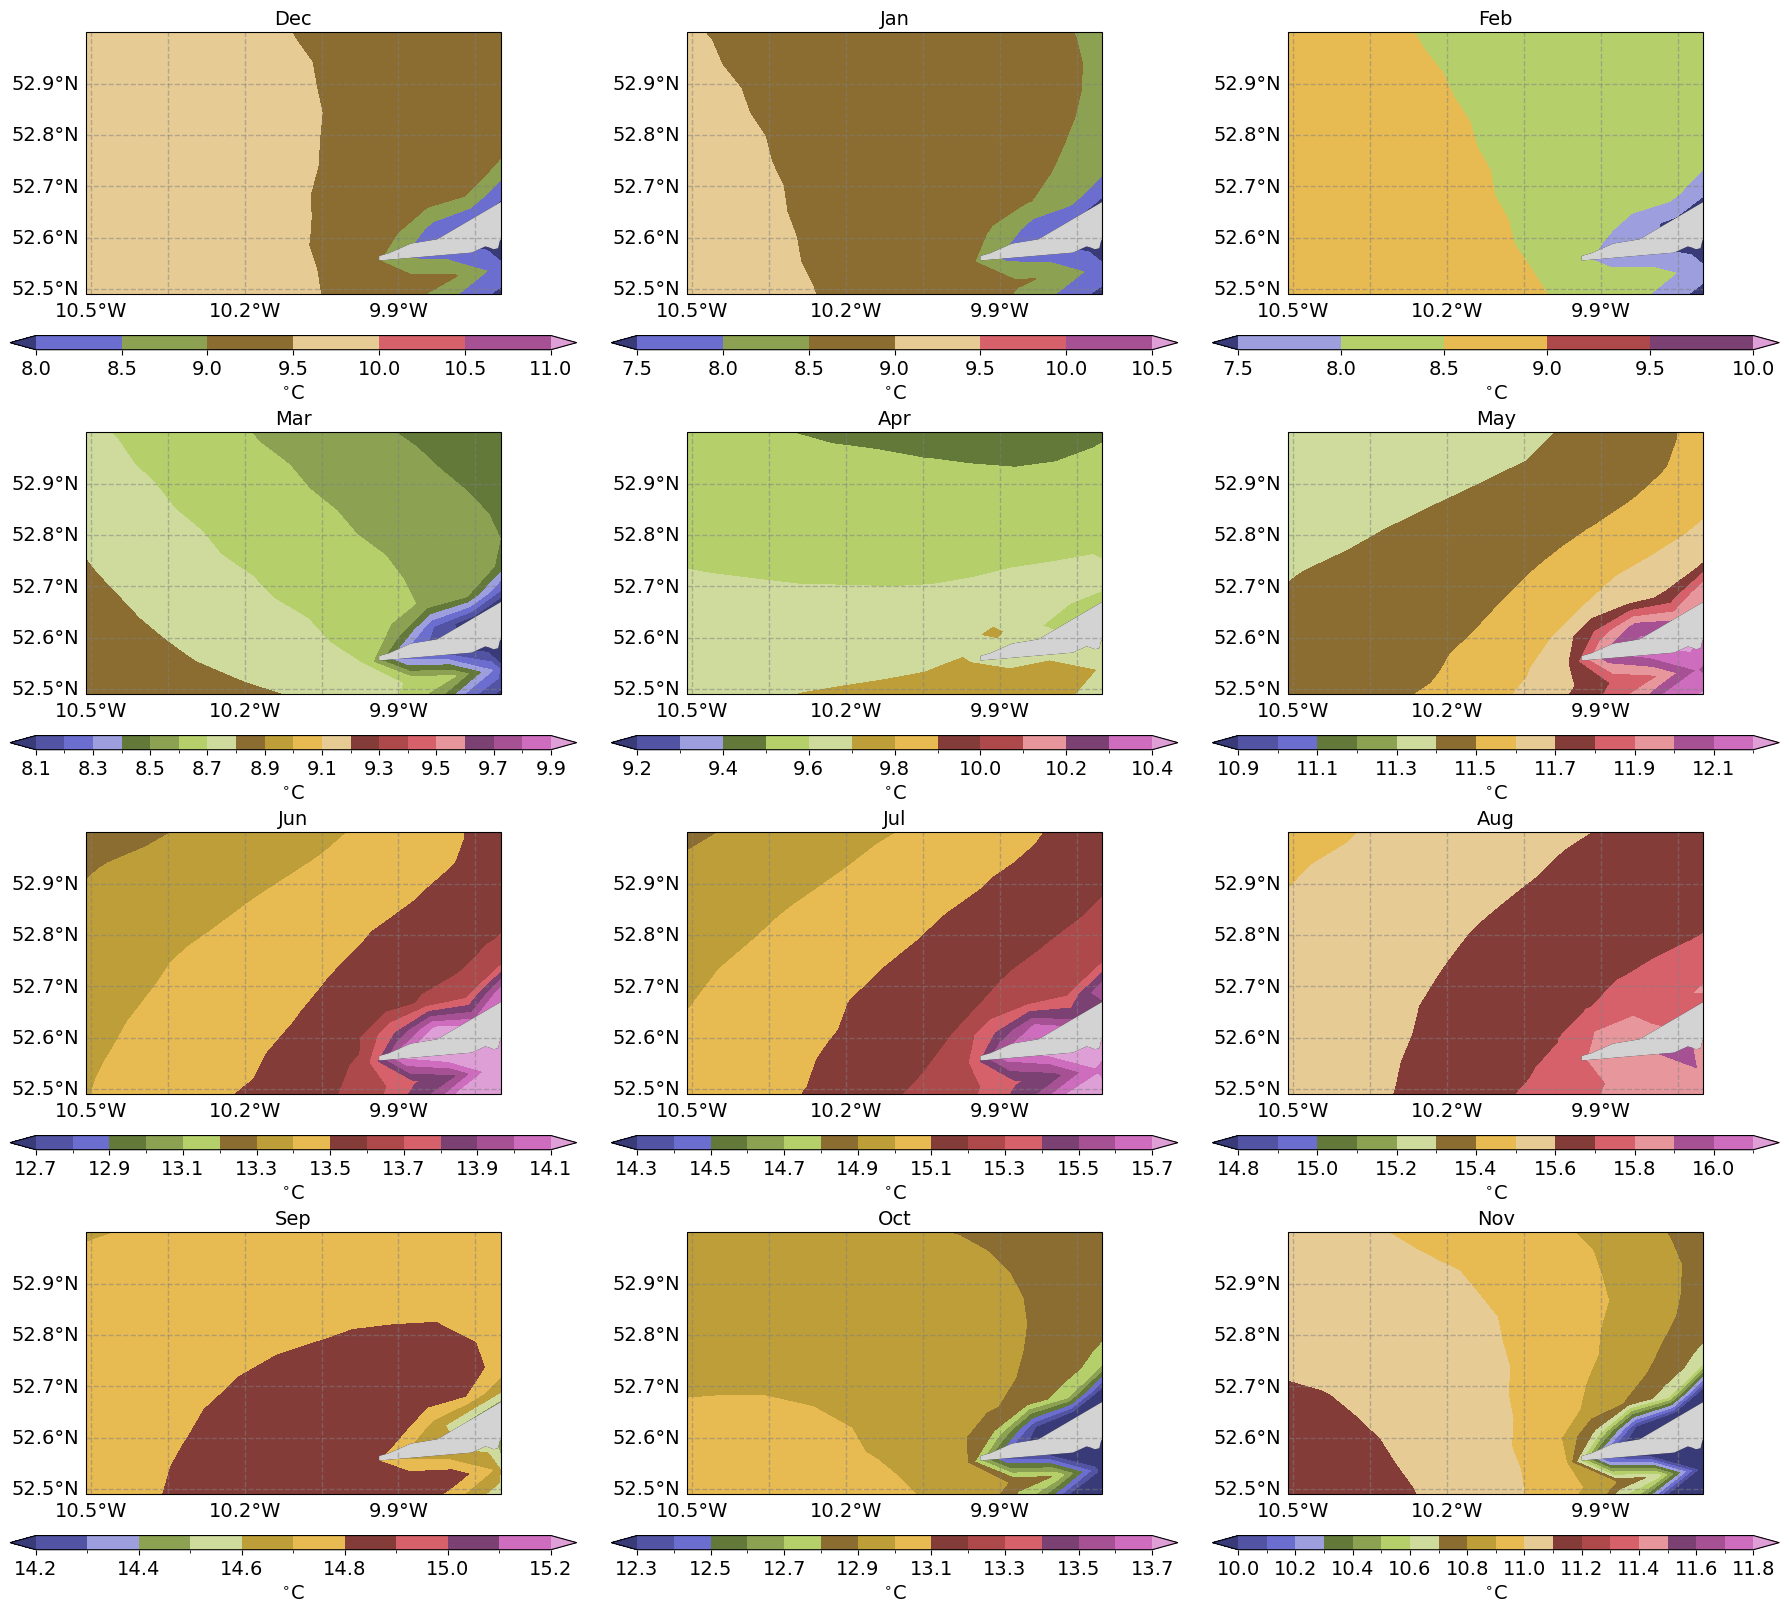

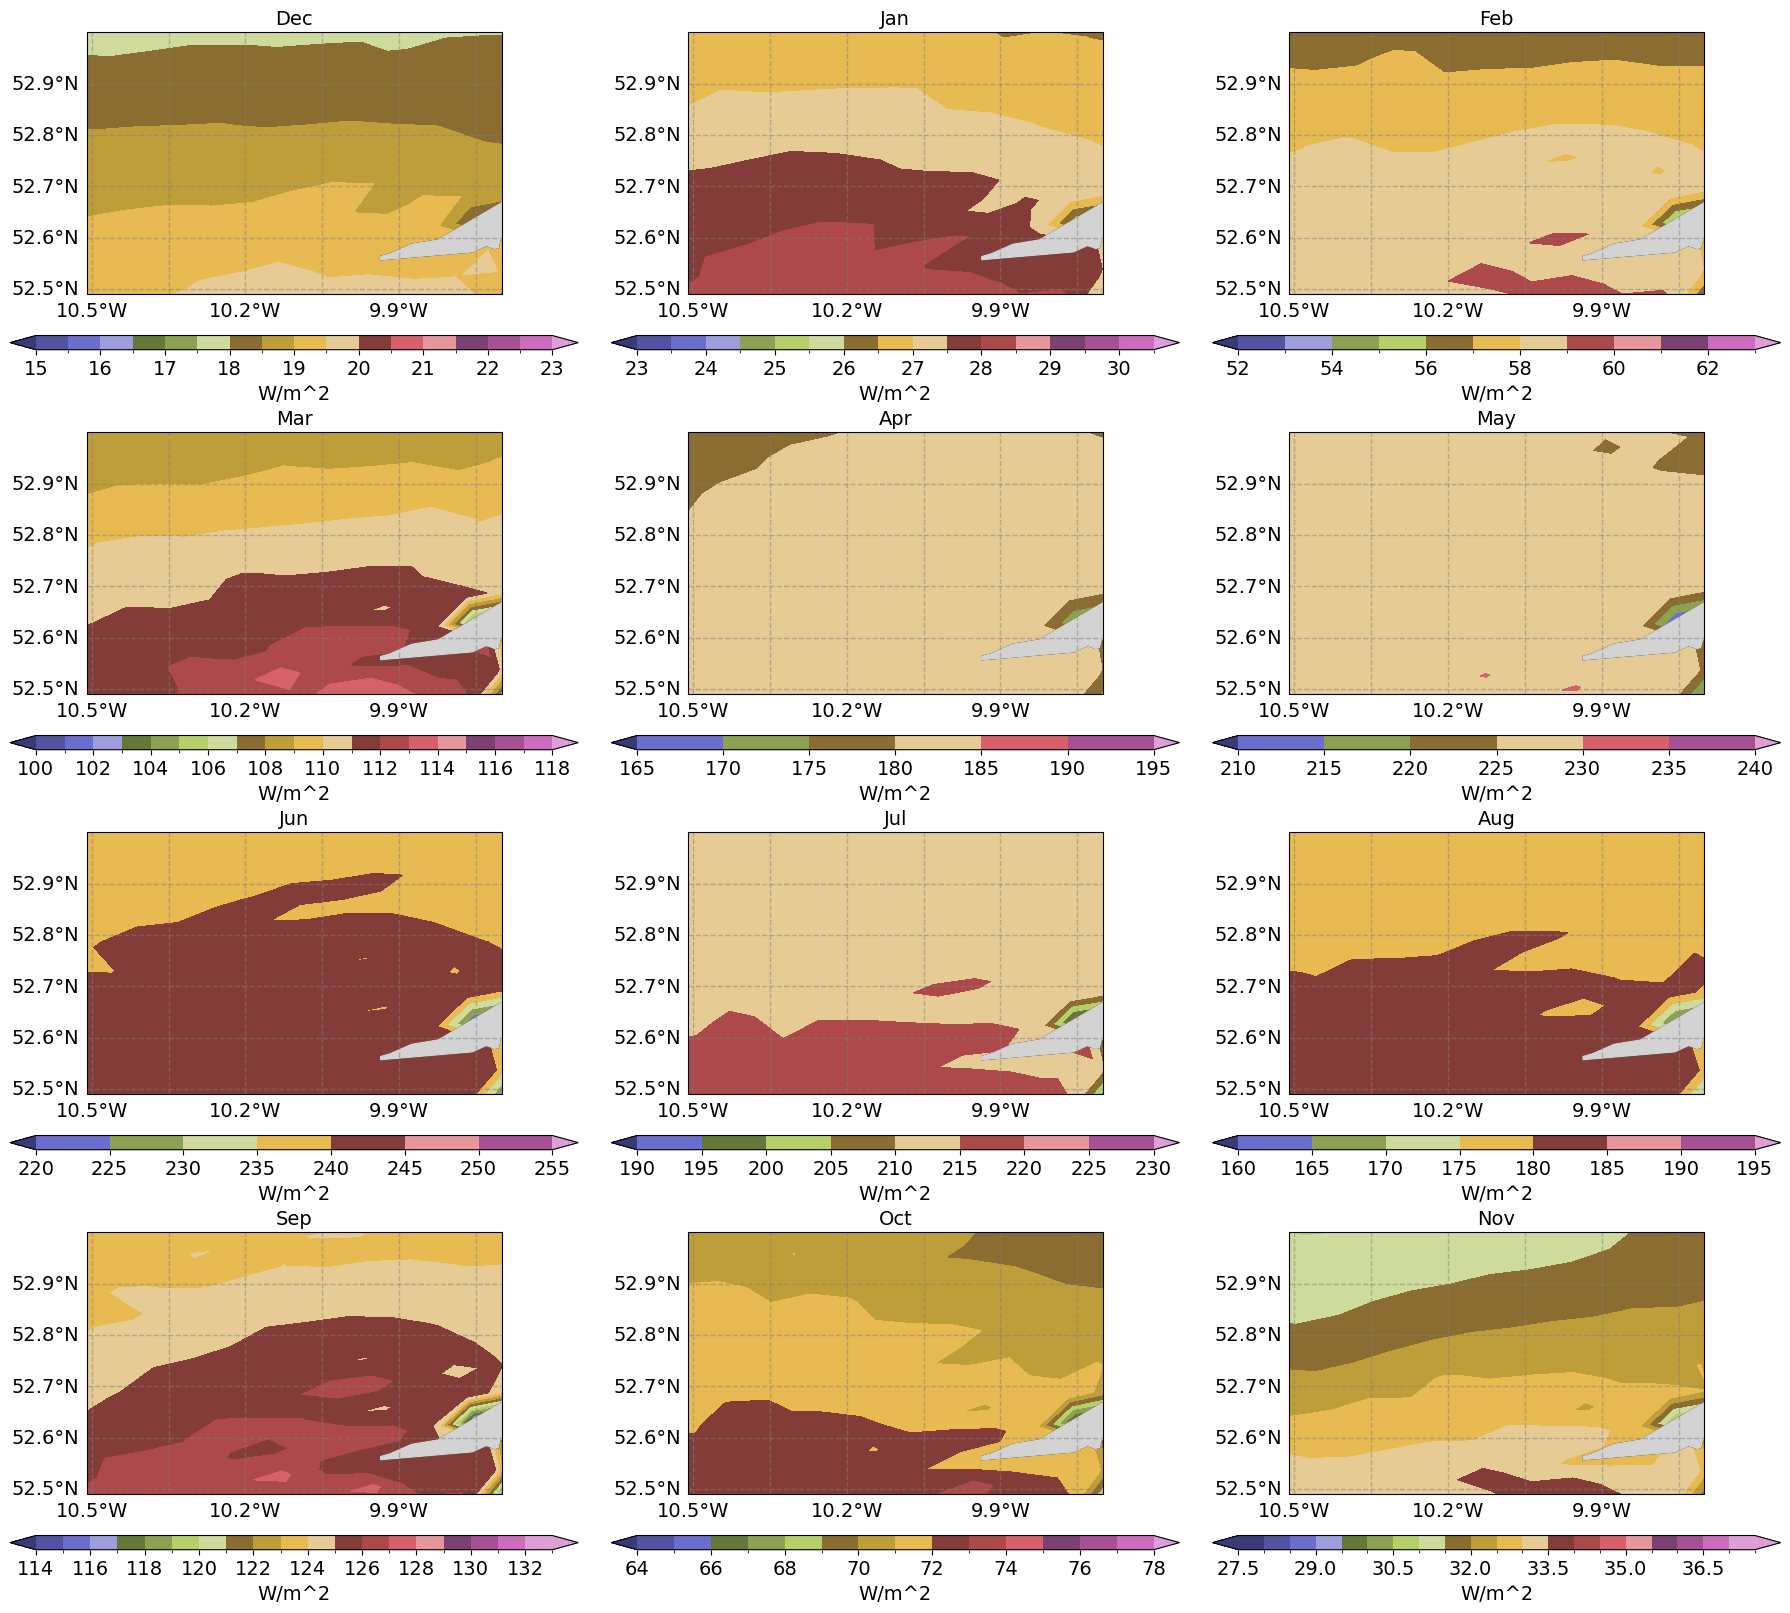

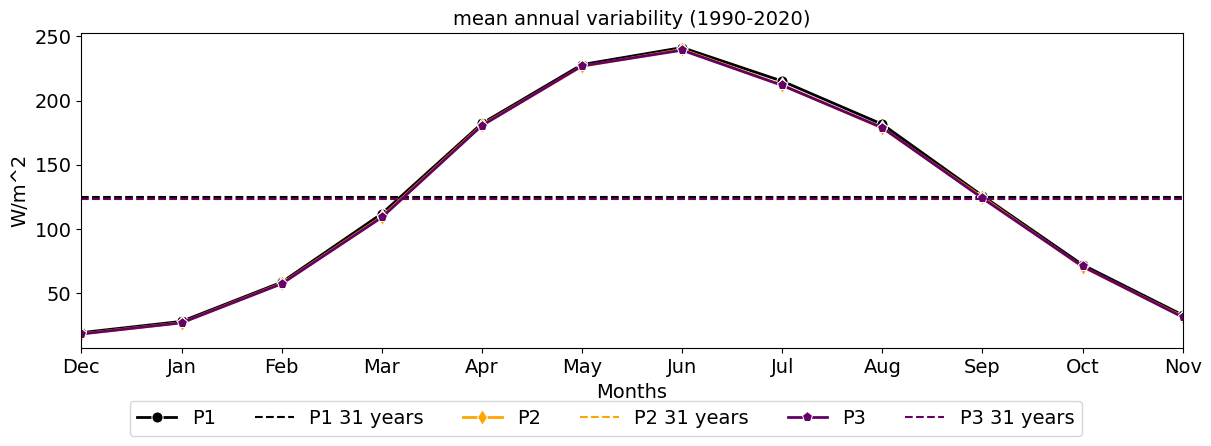

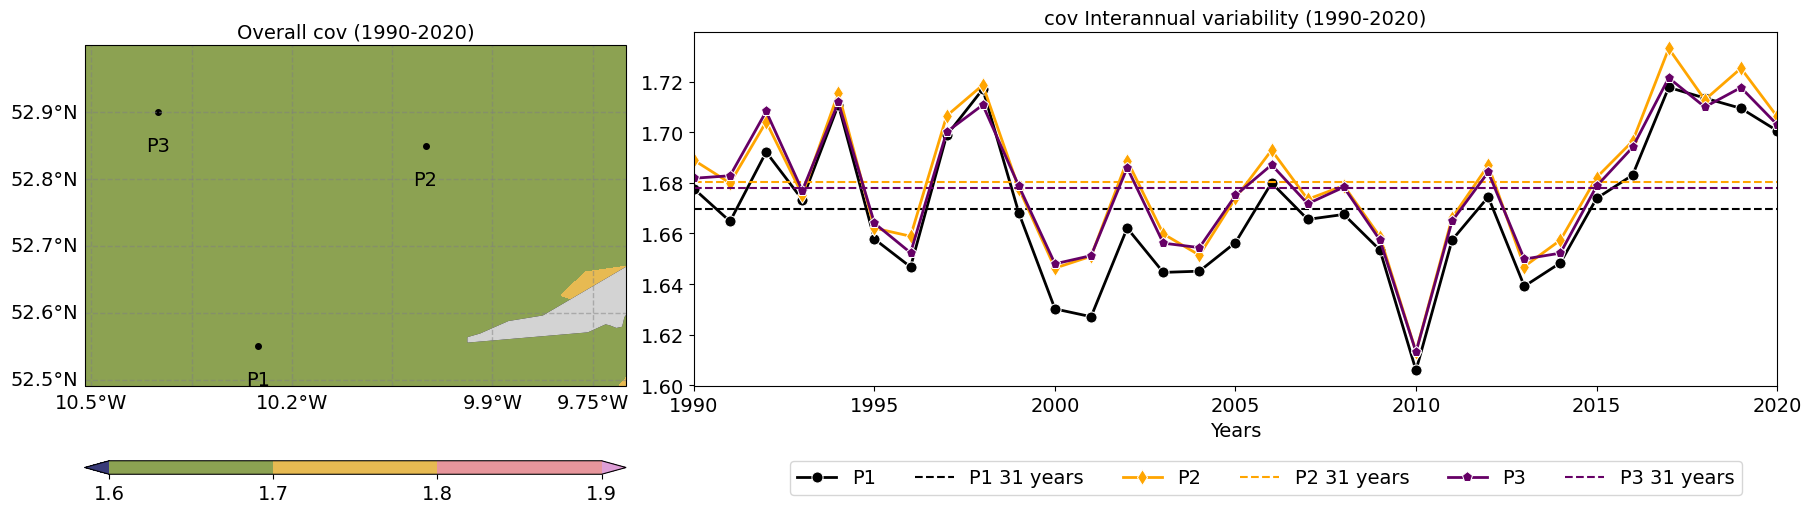

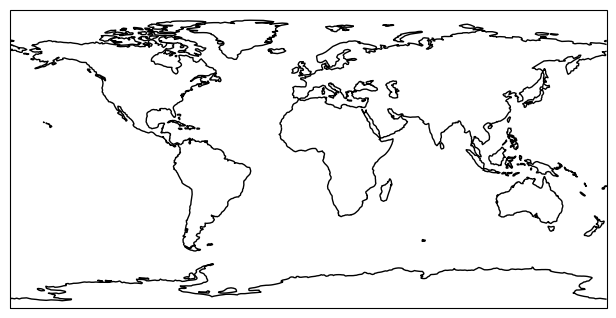

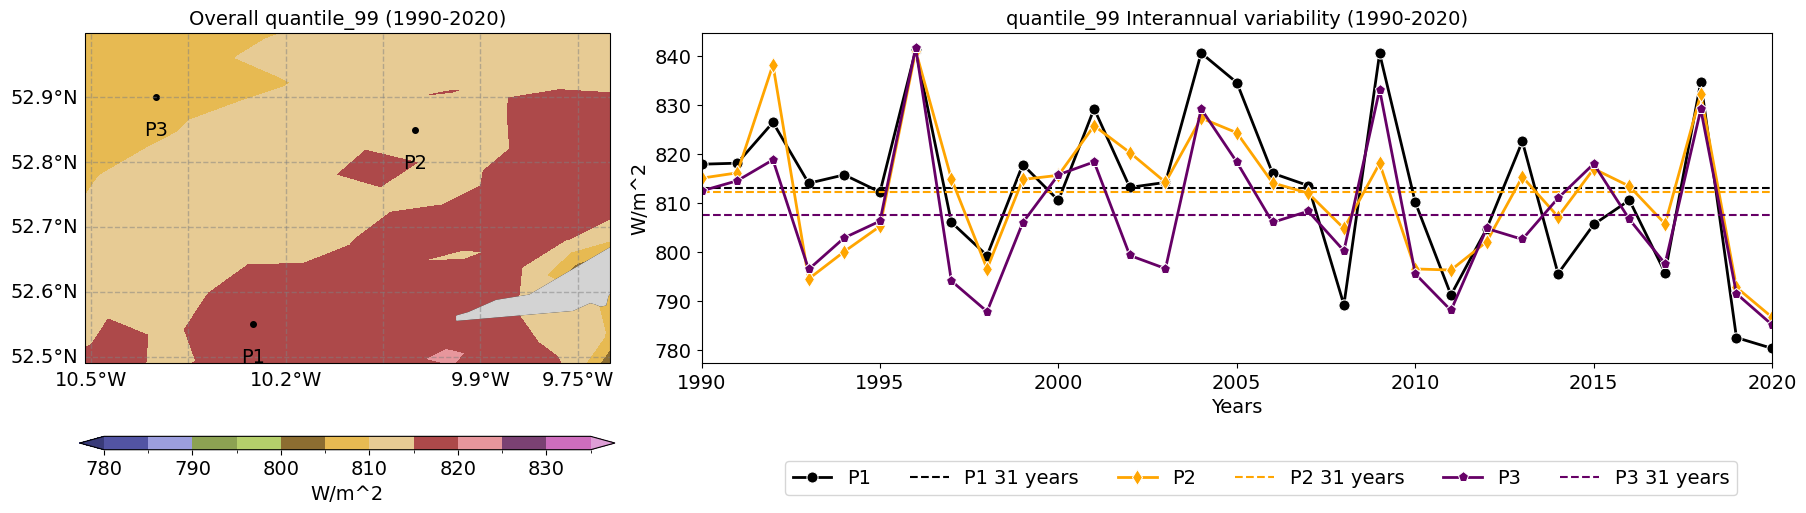

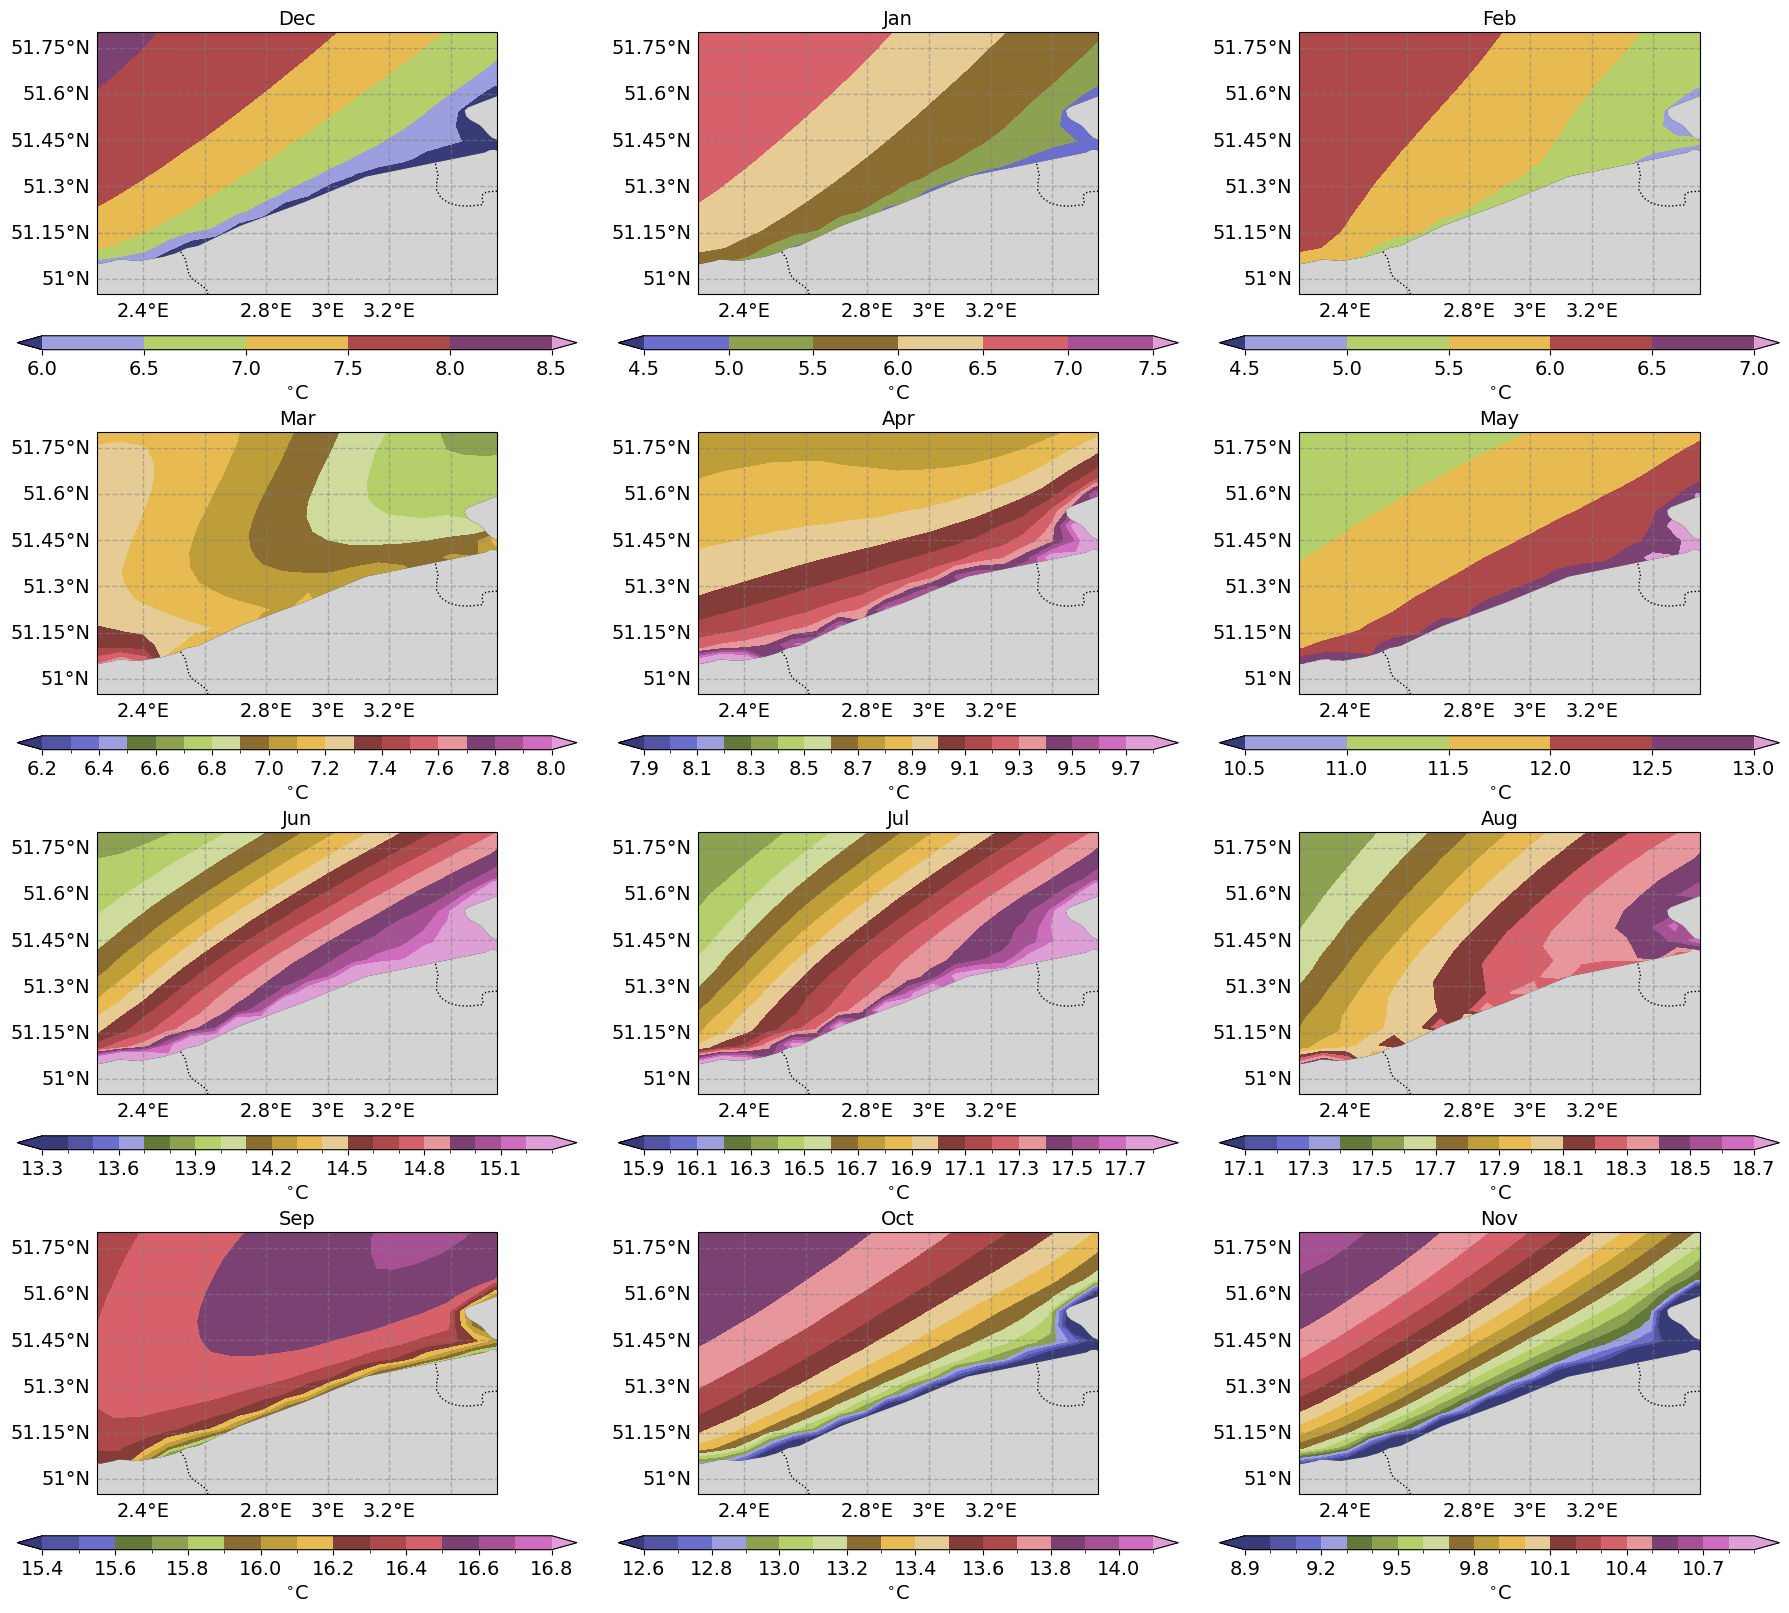

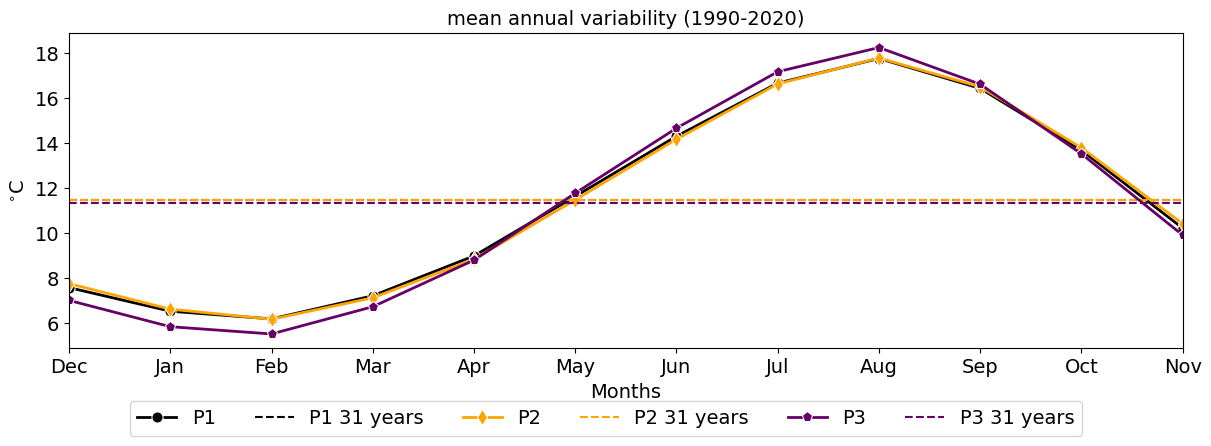

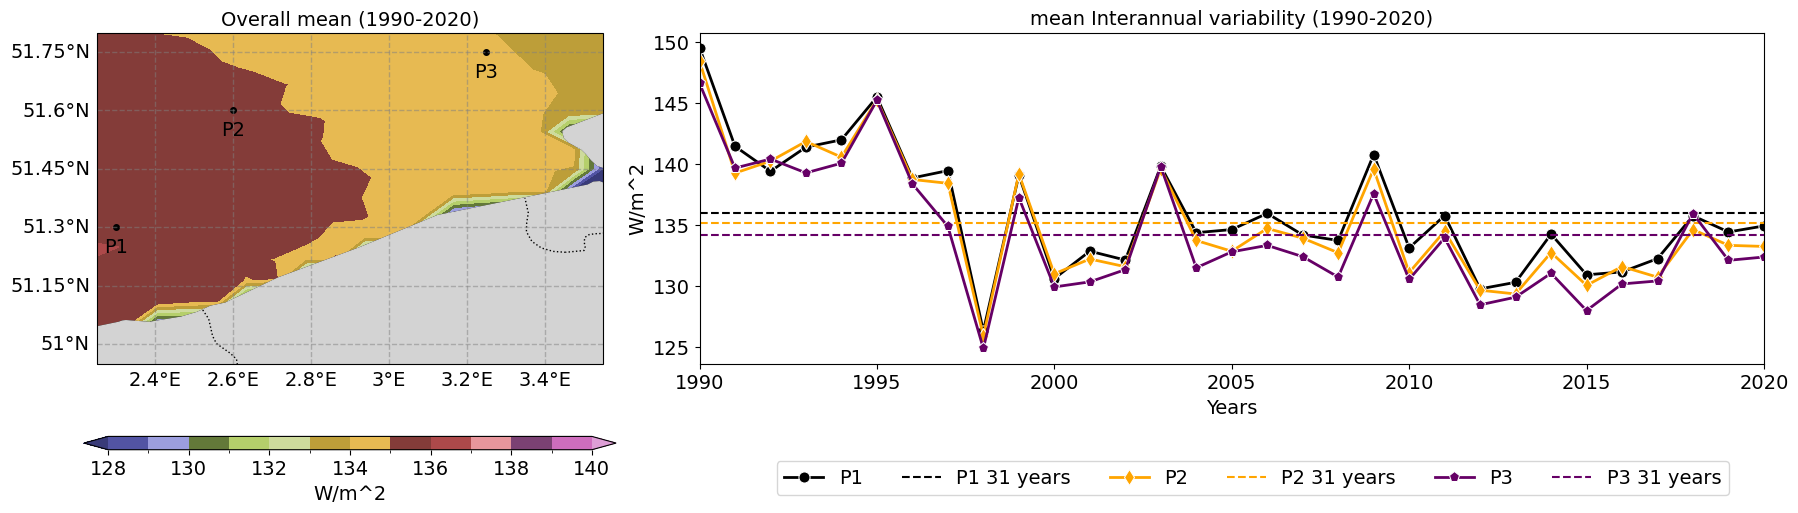

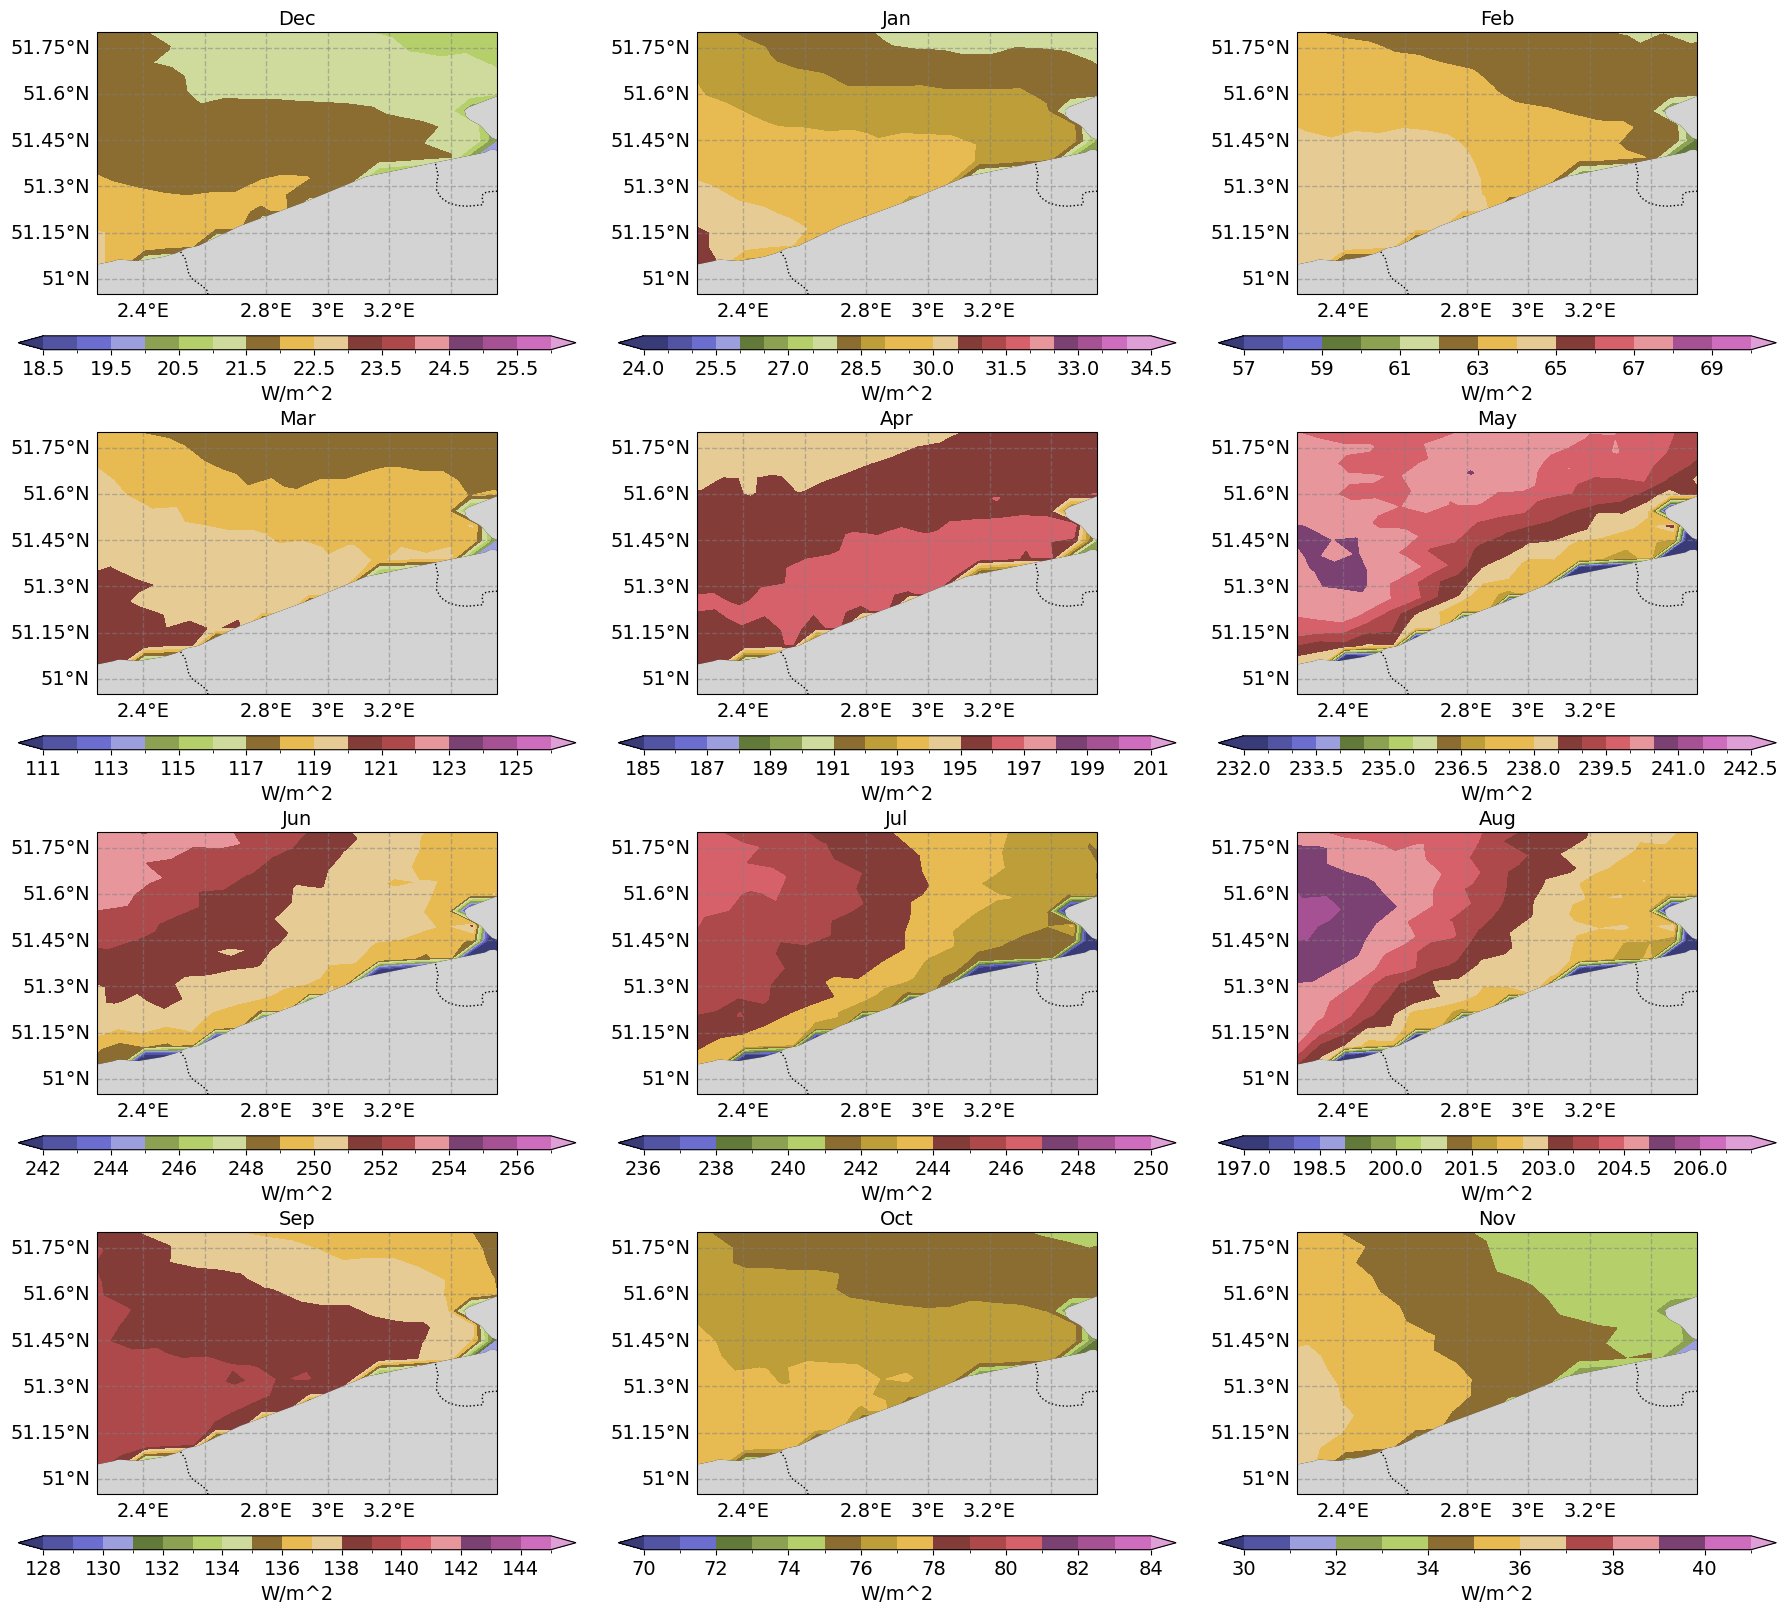

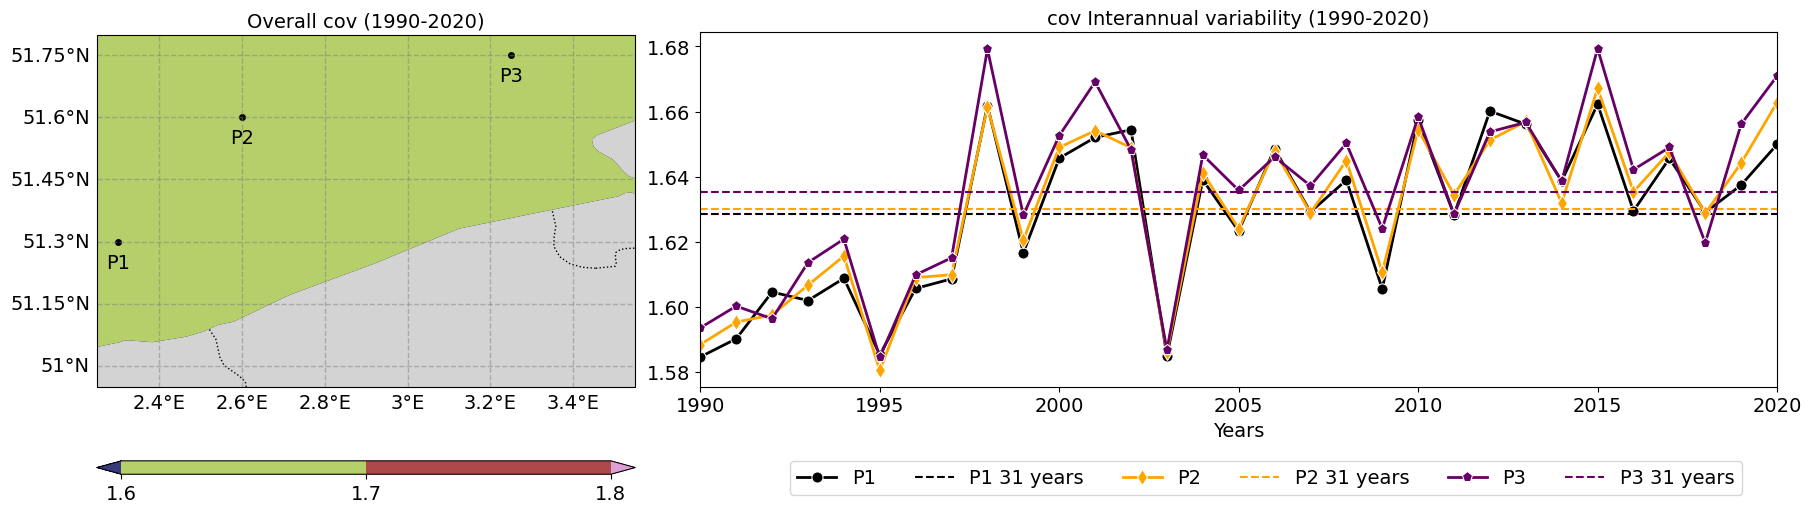

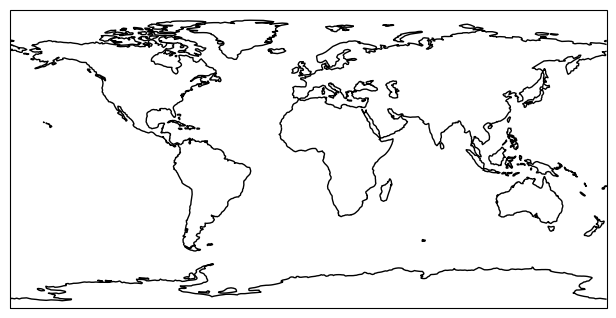

In [8]:
variables = {'ws':{'levels':[100,10], 'units':'m/s'},
             'wpd':{'levels':[100], 'units':'W/m^2'},
             't2m':{'units':r'$^{\circ}$C'},
             'swdown':{'units':'W/m^2'},
             'spv': {'units':'%'}, # spv is converted into CF
             'tp':{('turbine_type','level'):[(8,100),(15,100)],'units':'%'}} # tp is converted into CF
variables = {'t2m':{'units':r'$^{\circ}$C'},
             'swdown':{'units':'W/m^2'}}
statistics = ['weibull','mean','cov','quantile_5','quantile_95','quantile_99']
for case in cases:
    run_dir=f'{root_dir}/CERRA/{case}/variablewise_files'
    lsm = xr.open_dataset(f'{run_dir}/lsm.nc')['lsm']
    for variable, v_info in variables.items():
        if 'levels' in variables[variable]:
            for level in variables[variable]['levels']:
                target_dir = f'{root_dir}/CERRA/{case}/statistics_files/{variable}_{level}' 
                for statistic in statistics:
                    file_name = f'{target_dir}/{statistic}.nc'
                    target_fig_suffix = f'{fig_dir}/{case}_{variable}_{level}m_{statistic}'
                    if os.path.exists(file_name):
                        ds = xr.open_dataset(file_name)
                        try:
                            process_data(ds, target_dir,case,variable, statistic, v_info,target_fig_suffix,lsm)
                        except ValueError:
                            print(f"Filled contours require at least 2 levels: {target_fig_suffix}")
                    else:
                        None
        else:
            if variable == 'tp':
                for turbine_type, level in variables[variable][('turbine_type','level')]:
                    target_dir = f'{root_dir}/CERRA/{case}/statistics_files/{turbine_type}MW/tp_{level}'
                    for statistic in statistics:
                        file_name = f'{target_dir}/{statistic}.nc'
                        target_fig_suffix = f'{fig_dir}/{case}_{turbine_type}MW_{level}m_CF_{statistic}'
                        if os.path.exists(file_name):
                            ds = xr.open_dataset(file_name)
                            ds = ds*0.1/turbine_type
                            try:
                                process_data(ds, target_dir,case,variable, statistic, v_info,target_fig_suffix,lsm)
                            except ValueError:
                                print(f"Filled contours require at least 2 levels: {target_fig_suffix}")
                        else:
                            None
            elif variable == 'spv':
                target_dir = f'{root_dir}/CERRA/{case}/statistics_files/{variable}'
                for statistic in statistics:
                    file_name = f'{target_dir}/{statistic}.nc'
                    target_fig_suffix = f'{fig_dir}/{case}_{variable}_CF_{statistic}'
                    if os.path.exists(file_name):
                        ds = xr.open_dataset(file_name)
                        ds = ds*100/cell_watt
                        try:
                            process_data(ds, target_dir,case,variable, statistic, v_info,target_fig_suffix,lsm)
                        except ValueError:
                            print(f"Filled contours require at least 2 levels: {target_fig_suffix}")
                    else:
                        None
            else:
                target_dir = f'{root_dir}/CERRA/{case}/statistics_files/{variable}'
                for statistic in statistics:
                    file_name = f'{target_dir}/{statistic}.nc'
                    target_fig_suffix = f'{fig_dir}/{case}_{variable}_{statistic}'
                    if os.path.exists(file_name):
                        ds = xr.open_dataset(file_name)
                        try:
                            process_data(ds, target_dir,case,variable, statistic, v_info,target_fig_suffix,lsm)
                        except ValueError:
                            print(f"Filled contours require at least 2 levels: {target_fig_suffix}")
                    else:
                        None